In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "full"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 0
Categorical features: 0
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  18


number of constant cols:  198


Numerical Columns: 588
Categorical Columns: 10


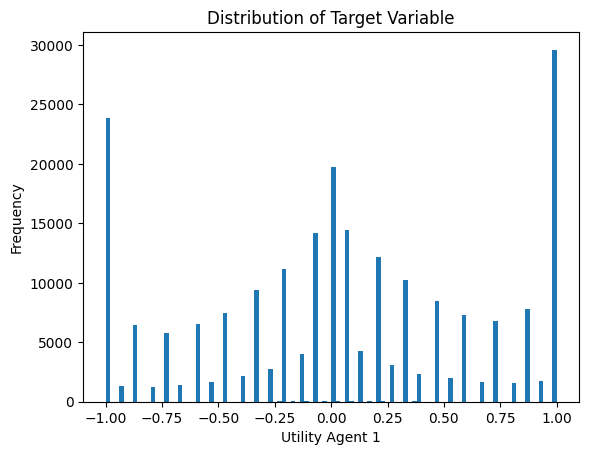

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6127167	test: 0.5486653	best: 0.5486653 (0)	total: 165ms	remaining: 8m 13s


50:	learn: 0.3829729	test: 0.4576529	best: 0.4576529 (50)	total: 5s	remaining: 4m 49s


100:	learn: 0.3421017	test: 0.4412584	best: 0.4412584 (100)	total: 10s	remaining: 4m 47s


150:	learn: 0.3210224	test: 0.4332371	best: 0.4332371 (150)	total: 15.2s	remaining: 4m 46s


200:	learn: 0.3053661	test: 0.4292646	best: 0.4292153 (199)	total: 20.4s	remaining: 4m 44s


250:	learn: 0.2944862	test: 0.4268011	best: 0.4268011 (250)	total: 25.5s	remaining: 4m 39s


300:	learn: 0.2842745	test: 0.4243537	best: 0.4243537 (300)	total: 30.5s	remaining: 4m 33s


350:	learn: 0.2760615	test: 0.4227140	best: 0.4226062 (347)	total: 35.5s	remaining: 4m 27s


400:	learn: 0.2695802	test: 0.4218192	best: 0.4218117 (398)	total: 41.1s	remaining: 4m 26s


450:	learn: 0.2638452	test: 0.4210091	best: 0.4209674 (447)	total: 46.2s	remaining: 4m 21s


500:	learn: 0.2587943	test: 0.4203196	best: 0.4203196 (500)	total: 51.1s	remaining: 4m 15s


550:	learn: 0.2535544	test: 0.4196280	best: 0.4196280 (550)	total: 56.2s	remaining: 4m 10s


600:	learn: 0.2484934	test: 0.4190202	best: 0.4190202 (600)	total: 1m 1s	remaining: 4m 4s


650:	learn: 0.2441719	test: 0.4183747	best: 0.4183696 (647)	total: 1m 6s	remaining: 3m 58s


700:	learn: 0.2404356	test: 0.4178338	best: 0.4178338 (700)	total: 1m 11s	remaining: 3m 53s


750:	learn: 0.2369524	test: 0.4174415	best: 0.4174415 (750)	total: 1m 16s	remaining: 3m 48s


800:	learn: 0.2335618	test: 0.4171442	best: 0.4171442 (800)	total: 1m 21s	remaining: 3m 43s


850:	learn: 0.2306026	test: 0.4169642	best: 0.4169379 (849)	total: 1m 26s	remaining: 3m 37s


900:	learn: 0.2277737	test: 0.4167319	best: 0.4167201 (891)	total: 1m 31s	remaining: 3m 32s


950:	learn: 0.2251039	test: 0.4166086	best: 0.4165921 (920)	total: 1m 36s	remaining: 3m 27s


1000:	learn: 0.2226763	test: 0.4162857	best: 0.4162361 (996)	total: 1m 41s	remaining: 3m 22s


1050:	learn: 0.2202339	test: 0.4160515	best: 0.4160515 (1050)	total: 1m 46s	remaining: 3m 17s


1100:	learn: 0.2175309	test: 0.4159028	best: 0.4158975 (1099)	total: 1m 51s	remaining: 3m 12s


1150:	learn: 0.2151079	test: 0.4158516	best: 0.4158290 (1122)	total: 1m 56s	remaining: 3m 7s


1200:	learn: 0.2127460	test: 0.4158345	best: 0.4157976 (1166)	total: 2m 2s	remaining: 3m 3s


1250:	learn: 0.2106284	test: 0.4158198	best: 0.4157736 (1216)	total: 2m 7s	remaining: 2m 58s


1300:	learn: 0.2083750	test: 0.4157202	best: 0.4157026 (1299)	total: 2m 12s	remaining: 2m 53s


1350:	learn: 0.2061651	test: 0.4156128	best: 0.4155653 (1329)	total: 2m 17s	remaining: 2m 48s


1400:	learn: 0.2040733	test: 0.4155479	best: 0.4155425 (1399)	total: 2m 23s	remaining: 2m 43s


1450:	learn: 0.2023237	test: 0.4155506	best: 0.4155345 (1438)	total: 2m 28s	remaining: 2m 38s


1500:	learn: 0.2005750	test: 0.4154498	best: 0.4154153 (1490)	total: 2m 33s	remaining: 2m 33s


1550:	learn: 0.1985299	test: 0.4153872	best: 0.4153766 (1547)	total: 2m 39s	remaining: 2m 28s


1600:	learn: 0.1966404	test: 0.4154289	best: 0.4153766 (1547)	total: 2m 44s	remaining: 2m 23s


1650:	learn: 0.1945724	test: 0.4152157	best: 0.4152157 (1650)	total: 2m 49s	remaining: 2m 18s


1700:	learn: 0.1928910	test: 0.4151680	best: 0.4151596 (1696)	total: 2m 55s	remaining: 2m 13s


1750:	learn: 0.1910474	test: 0.4151927	best: 0.4151596 (1696)	total: 3m	remaining: 2m 8s


1800:	learn: 0.1895170	test: 0.4151144	best: 0.4150987 (1798)	total: 3m 5s	remaining: 2m 3s


1850:	learn: 0.1879752	test: 0.4151388	best: 0.4150987 (1798)	total: 3m 11s	remaining: 1m 58s


1900:	learn: 0.1862422	test: 0.4151727	best: 0.4150987 (1798)	total: 3m 16s	remaining: 1m 53s


1950:	learn: 0.1848234	test: 0.4150798	best: 0.4150796 (1948)	total: 3m 22s	remaining: 1m 48s


2000:	learn: 0.1833612	test: 0.4150706	best: 0.4150271 (1970)	total: 3m 27s	remaining: 1m 43s


2050:	learn: 0.1818478	test: 0.4151385	best: 0.4150271 (1970)	total: 3m 33s	remaining: 1m 38s


2100:	learn: 0.1805763	test: 0.4150876	best: 0.4150271 (1970)	total: 3m 38s	remaining: 1m 33s


2150:	learn: 0.1791314	test: 0.4151175	best: 0.4150271 (1970)	total: 3m 44s	remaining: 1m 28s


2200:	learn: 0.1778535	test: 0.4151352	best: 0.4150271 (1970)	total: 3m 49s	remaining: 1m 23s


2250:	learn: 0.1762946	test: 0.4151436	best: 0.4150271 (1970)	total: 3m 55s	remaining: 1m 18s


2300:	learn: 0.1749535	test: 0.4150683	best: 0.4150271 (1970)	total: 4m	remaining: 1m 13s


2350:	learn: 0.1737268	test: 0.4151293	best: 0.4150271 (1970)	total: 4m 6s	remaining: 1m 8s


2400:	learn: 0.1722923	test: 0.4151836	best: 0.4150271 (1970)	total: 4m 12s	remaining: 1m 2s


2450:	learn: 0.1709548	test: 0.4151757	best: 0.4150271 (1970)	total: 4m 17s	remaining: 57.8s


2500:	learn: 0.1695724	test: 0.4151108	best: 0.4150271 (1970)	total: 4m 23s	remaining: 52.6s


2550:	learn: 0.1684513	test: 0.4151261	best: 0.4150271 (1970)	total: 4m 29s	remaining: 47.4s


2600:	learn: 0.1673248	test: 0.4151192	best: 0.4150271 (1970)	total: 4m 35s	remaining: 42.2s


2650:	learn: 0.1659322	test: 0.4151099	best: 0.4150271 (1970)	total: 4m 40s	remaining: 37s


2700:	learn: 0.1646327	test: 0.4151251	best: 0.4150271 (1970)	total: 4m 46s	remaining: 31.7s


2750:	learn: 0.1631965	test: 0.4151877	best: 0.4150271 (1970)	total: 4m 51s	remaining: 26.4s


2800:	learn: 0.1620626	test: 0.4151739	best: 0.4150271 (1970)	total: 4m 57s	remaining: 21.1s


2850:	learn: 0.1609857	test: 0.4151869	best: 0.4150271 (1970)	total: 5m 2s	remaining: 15.8s


2900:	learn: 0.1597359	test: 0.4151604	best: 0.4150271 (1970)	total: 5m 8s	remaining: 10.5s


2950:	learn: 0.1585846	test: 0.4152289	best: 0.4150271 (1970)	total: 5m 13s	remaining: 5.21s


2999:	learn: 0.1574586	test: 0.4152164	best: 0.4150271 (1970)	total: 5m 19s	remaining: 0us

bestTest = 0.4150270989
bestIteration = 1970

Shrink model to first 1971 iterations.


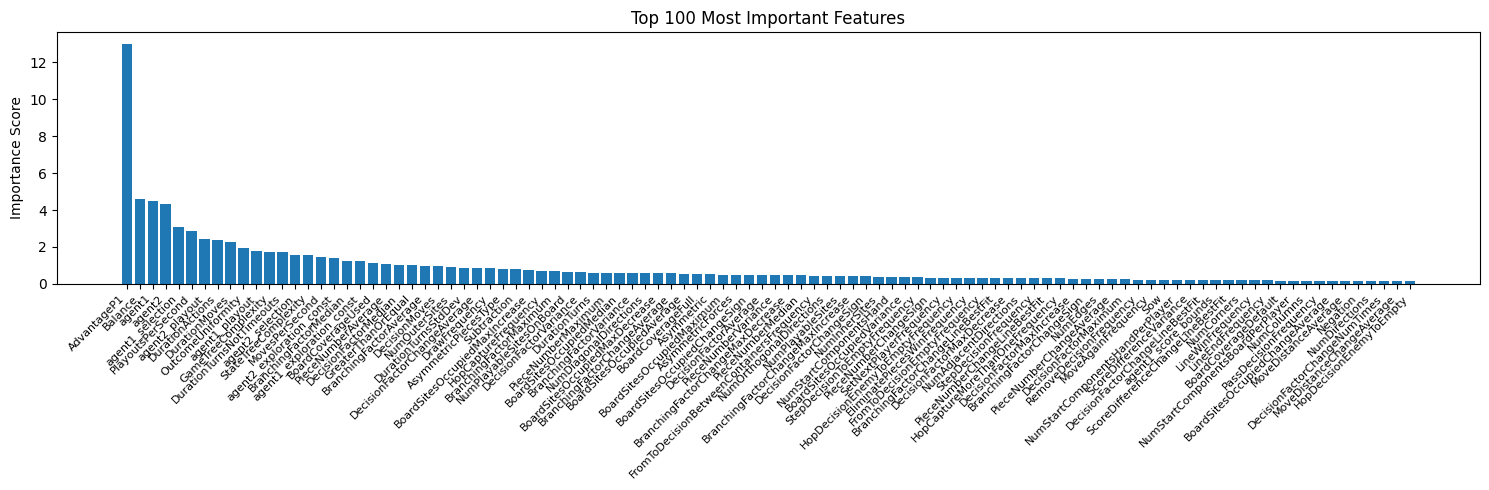

Fold 1 - RMSE: 0.41473341825229054
Fold 2


0:	learn: 0.6057644	test: 0.5785526	best: 0.5785526 (0)	total: 114ms	remaining: 5m 41s


50:	learn: 0.3919989	test: 0.4761254	best: 0.4761254 (50)	total: 5.57s	remaining: 5m 21s


100:	learn: 0.3520228	test: 0.4605613	best: 0.4605613 (100)	total: 11.1s	remaining: 5m 17s


150:	learn: 0.3288230	test: 0.4537394	best: 0.4537394 (150)	total: 16.4s	remaining: 5m 9s


200:	learn: 0.3136009	test: 0.4507435	best: 0.4507356 (199)	total: 21.9s	remaining: 5m 4s


250:	learn: 0.3019942	test: 0.4472944	best: 0.4472944 (250)	total: 27.3s	remaining: 4m 59s


300:	learn: 0.2928075	test: 0.4460207	best: 0.4460096 (294)	total: 33.2s	remaining: 4m 57s


350:	learn: 0.2850960	test: 0.4448987	best: 0.4448987 (350)	total: 38.7s	remaining: 4m 51s


400:	learn: 0.2775336	test: 0.4441409	best: 0.4440441 (388)	total: 44.2s	remaining: 4m 46s


450:	learn: 0.2712504	test: 0.4430897	best: 0.4430706 (447)	total: 49.7s	remaining: 4m 41s


500:	learn: 0.2653539	test: 0.4425643	best: 0.4425643 (500)	total: 55.2s	remaining: 4m 35s


550:	learn: 0.2605001	test: 0.4420345	best: 0.4419524 (540)	total: 1m	remaining: 4m 29s


600:	learn: 0.2557974	test: 0.4415734	best: 0.4415734 (600)	total: 1m 6s	remaining: 4m 24s


650:	learn: 0.2512804	test: 0.4409230	best: 0.4409230 (650)	total: 1m 12s	remaining: 4m 20s


700:	learn: 0.2476946	test: 0.4405246	best: 0.4404364 (691)	total: 1m 17s	remaining: 4m 15s


750:	learn: 0.2442528	test: 0.4402565	best: 0.4402565 (750)	total: 1m 23s	remaining: 4m 10s


800:	learn: 0.2409307	test: 0.4399026	best: 0.4399026 (800)	total: 1m 29s	remaining: 4m 5s


850:	learn: 0.2378201	test: 0.4397549	best: 0.4396918 (835)	total: 1m 34s	remaining: 3m 59s


900:	learn: 0.2349246	test: 0.4396872	best: 0.4396872 (900)	total: 1m 40s	remaining: 3m 54s


950:	learn: 0.2323599	test: 0.4396165	best: 0.4396165 (950)	total: 1m 46s	remaining: 3m 49s


1000:	learn: 0.2299592	test: 0.4395932	best: 0.4395259 (997)	total: 1m 52s	remaining: 3m 44s


1050:	learn: 0.2276430	test: 0.4393271	best: 0.4393100 (1047)	total: 1m 57s	remaining: 3m 38s


1100:	learn: 0.2251216	test: 0.4394123	best: 0.4393100 (1047)	total: 2m 3s	remaining: 3m 33s


1150:	learn: 0.2224974	test: 0.4392310	best: 0.4392089 (1118)	total: 2m 9s	remaining: 3m 28s


1200:	learn: 0.2201366	test: 0.4391251	best: 0.4391100 (1197)	total: 2m 15s	remaining: 3m 22s


1250:	learn: 0.2178682	test: 0.4391647	best: 0.4390632 (1212)	total: 2m 20s	remaining: 3m 16s


1300:	learn: 0.2156082	test: 0.4390565	best: 0.4389915 (1292)	total: 2m 26s	remaining: 3m 11s


1350:	learn: 0.2132421	test: 0.4388860	best: 0.4388699 (1344)	total: 2m 32s	remaining: 3m 5s


1400:	learn: 0.2110365	test: 0.4388299	best: 0.4388009 (1372)	total: 2m 37s	remaining: 3m


1450:	learn: 0.2091143	test: 0.4388349	best: 0.4388009 (1372)	total: 2m 43s	remaining: 2m 54s


1500:	learn: 0.2071978	test: 0.4387391	best: 0.4387270 (1478)	total: 2m 49s	remaining: 2m 49s


1550:	learn: 0.2056293	test: 0.4387079	best: 0.4386547 (1528)	total: 2m 55s	remaining: 2m 43s


1600:	learn: 0.2041231	test: 0.4386672	best: 0.4386420 (1559)	total: 3m 1s	remaining: 2m 38s


1650:	learn: 0.2024810	test: 0.4385944	best: 0.4385892 (1648)	total: 3m 7s	remaining: 2m 32s


1700:	learn: 0.2006802	test: 0.4385640	best: 0.4385441 (1680)	total: 3m 12s	remaining: 2m 27s


1750:	learn: 0.1988838	test: 0.4383705	best: 0.4383640 (1749)	total: 3m 18s	remaining: 2m 21s


1800:	learn: 0.1972971	test: 0.4383338	best: 0.4383241 (1799)	total: 3m 24s	remaining: 2m 16s


1850:	learn: 0.1955454	test: 0.4381783	best: 0.4381761 (1848)	total: 3m 30s	remaining: 2m 10s


1900:	learn: 0.1939730	test: 0.4380709	best: 0.4380504 (1883)	total: 3m 36s	remaining: 2m 4s


1950:	learn: 0.1923472	test: 0.4380578	best: 0.4380326 (1943)	total: 3m 41s	remaining: 1m 59s


2000:	learn: 0.1907652	test: 0.4379869	best: 0.4379641 (1991)	total: 3m 47s	remaining: 1m 53s


2050:	learn: 0.1891368	test: 0.4378851	best: 0.4378819 (2049)	total: 3m 54s	remaining: 1m 48s


2100:	learn: 0.1875267	test: 0.4378361	best: 0.4378228 (2086)	total: 4m	remaining: 1m 42s


2150:	learn: 0.1861156	test: 0.4378823	best: 0.4378228 (2086)	total: 4m 6s	remaining: 1m 37s


2200:	learn: 0.1847048	test: 0.4376863	best: 0.4376703 (2191)	total: 4m 13s	remaining: 1m 31s


2250:	learn: 0.1832034	test: 0.4376194	best: 0.4376148 (2240)	total: 4m 19s	remaining: 1m 26s


2300:	learn: 0.1817941	test: 0.4375670	best: 0.4375608 (2291)	total: 4m 25s	remaining: 1m 20s


2350:	learn: 0.1805115	test: 0.4375842	best: 0.4375409 (2305)	total: 4m 32s	remaining: 1m 15s


2400:	learn: 0.1792627	test: 0.4375793	best: 0.4375409 (2305)	total: 4m 39s	remaining: 1m 9s


2450:	learn: 0.1779252	test: 0.4375987	best: 0.4375409 (2305)	total: 4m 45s	remaining: 1m 3s


2500:	learn: 0.1767007	test: 0.4376290	best: 0.4375409 (2305)	total: 4m 52s	remaining: 58.3s


2550:	learn: 0.1753374	test: 0.4375359	best: 0.4375353 (2548)	total: 4m 58s	remaining: 52.6s


2600:	learn: 0.1739041	test: 0.4374679	best: 0.4374642 (2599)	total: 5m 5s	remaining: 46.9s


2650:	learn: 0.1725221	test: 0.4375021	best: 0.4374584 (2603)	total: 5m 12s	remaining: 41.1s


2700:	learn: 0.1714235	test: 0.4374417	best: 0.4374385 (2698)	total: 5m 18s	remaining: 35.3s


2750:	learn: 0.1701632	test: 0.4374299	best: 0.4374146 (2745)	total: 5m 25s	remaining: 29.5s


2800:	learn: 0.1690671	test: 0.4373922	best: 0.4373894 (2797)	total: 5m 32s	remaining: 23.6s


2850:	learn: 0.1679805	test: 0.4374131	best: 0.4373751 (2804)	total: 5m 38s	remaining: 17.7s


2900:	learn: 0.1671222	test: 0.4374193	best: 0.4373751 (2804)	total: 5m 45s	remaining: 11.8s


2950:	learn: 0.1660359	test: 0.4374485	best: 0.4373751 (2804)	total: 5m 52s	remaining: 5.84s


2999:	learn: 0.1649544	test: 0.4374581	best: 0.4373751 (2804)	total: 5m 58s	remaining: 0us

bestTest = 0.437375066
bestIteration = 2804

Shrink model to first 2805 iterations.


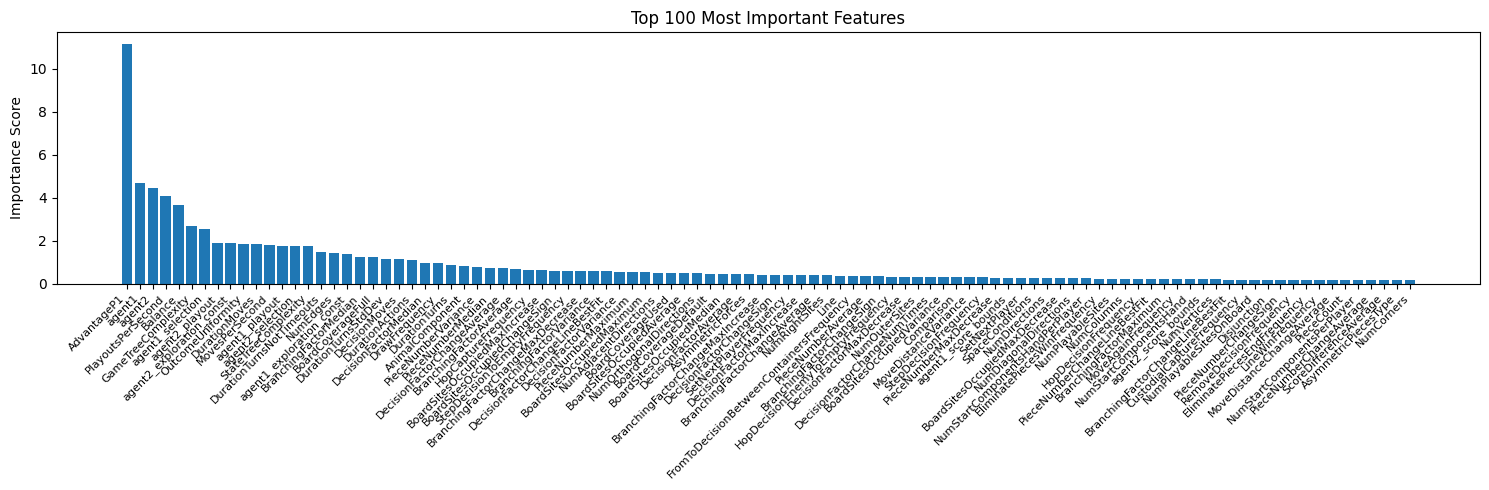

Fold 2 - RMSE: 0.4370922255959416
Fold 3


0:	learn: 0.6019307	test: 0.5983120	best: 0.5983120 (0)	total: 99.2ms	remaining: 4m 57s


50:	learn: 0.3880711	test: 0.4657229	best: 0.4654702 (49)	total: 6.19s	remaining: 5m 57s


100:	learn: 0.3514076	test: 0.4474566	best: 0.4474566 (100)	total: 12.7s	remaining: 6m 3s


150:	learn: 0.3297371	test: 0.4396884	best: 0.4396884 (150)	total: 19.3s	remaining: 6m 4s


200:	learn: 0.3154119	test: 0.4366173	best: 0.4366173 (200)	total: 25.7s	remaining: 5m 57s


250:	learn: 0.3037909	test: 0.4344570	best: 0.4343686 (247)	total: 31.8s	remaining: 5m 48s


300:	learn: 0.2944527	test: 0.4324799	best: 0.4324643 (299)	total: 37.9s	remaining: 5m 40s


350:	learn: 0.2864799	test: 0.4311518	best: 0.4311518 (350)	total: 44s	remaining: 5m 32s


400:	learn: 0.2802463	test: 0.4304369	best: 0.4304021 (398)	total: 50.3s	remaining: 5m 26s


450:	learn: 0.2739322	test: 0.4296513	best: 0.4295979 (447)	total: 56.7s	remaining: 5m 20s


500:	learn: 0.2683232	test: 0.4291610	best: 0.4290753 (491)	total: 1m 3s	remaining: 5m 15s


550:	learn: 0.2631432	test: 0.4284116	best: 0.4283998 (547)	total: 1m 9s	remaining: 5m 8s


600:	learn: 0.2586832	test: 0.4278123	best: 0.4277888 (599)	total: 1m 16s	remaining: 5m 3s


650:	learn: 0.2543149	test: 0.4272788	best: 0.4272380 (649)	total: 1m 22s	remaining: 4m 58s


700:	learn: 0.2502991	test: 0.4269166	best: 0.4269118 (697)	total: 1m 28s	remaining: 4m 51s


750:	learn: 0.2467634	test: 0.4268842	best: 0.4268349 (734)	total: 1m 35s	remaining: 4m 44s


800:	learn: 0.2432663	test: 0.4264415	best: 0.4264386 (797)	total: 1m 41s	remaining: 4m 37s


850:	learn: 0.2401460	test: 0.4262475	best: 0.4262402 (834)	total: 1m 47s	remaining: 4m 31s


900:	learn: 0.2374285	test: 0.4259552	best: 0.4259481 (882)	total: 1m 53s	remaining: 4m 25s


950:	learn: 0.2344906	test: 0.4257595	best: 0.4257416 (940)	total: 1m 59s	remaining: 4m 18s


1000:	learn: 0.2313091	test: 0.4255332	best: 0.4255142 (996)	total: 2m 5s	remaining: 4m 11s


1050:	learn: 0.2286351	test: 0.4256641	best: 0.4255142 (996)	total: 2m 11s	remaining: 4m 4s


1100:	learn: 0.2260490	test: 0.4254000	best: 0.4253985 (1098)	total: 2m 18s	remaining: 3m 58s


1150:	learn: 0.2237445	test: 0.4252327	best: 0.4252118 (1139)	total: 2m 24s	remaining: 3m 51s


1200:	learn: 0.2213769	test: 0.4250535	best: 0.4250448 (1194)	total: 2m 30s	remaining: 3m 45s


1250:	learn: 0.2190898	test: 0.4250483	best: 0.4250448 (1194)	total: 2m 36s	remaining: 3m 38s


1300:	learn: 0.2169596	test: 0.4250149	best: 0.4250149 (1300)	total: 2m 42s	remaining: 3m 31s


1350:	learn: 0.2147582	test: 0.4247718	best: 0.4247713 (1348)	total: 2m 48s	remaining: 3m 25s


1400:	learn: 0.2128319	test: 0.4245940	best: 0.4245758 (1393)	total: 2m 54s	remaining: 3m 19s


1450:	learn: 0.2108732	test: 0.4245979	best: 0.4245535 (1444)	total: 3m	remaining: 3m 12s


1500:	learn: 0.2087196	test: 0.4245390	best: 0.4245146 (1494)	total: 3m 6s	remaining: 3m 6s


1550:	learn: 0.2067673	test: 0.4245313	best: 0.4245093 (1544)	total: 3m 12s	remaining: 2m 59s


1600:	learn: 0.2048701	test: 0.4243868	best: 0.4243868 (1600)	total: 3m 18s	remaining: 2m 53s


1650:	learn: 0.2030387	test: 0.4244055	best: 0.4243575 (1643)	total: 3m 24s	remaining: 2m 47s


1700:	learn: 0.2012983	test: 0.4243652	best: 0.4243480 (1690)	total: 3m 30s	remaining: 2m 40s


1750:	learn: 0.1995258	test: 0.4242553	best: 0.4242553 (1750)	total: 3m 36s	remaining: 2m 34s


1800:	learn: 0.1977360	test: 0.4242059	best: 0.4241867 (1782)	total: 3m 42s	remaining: 2m 28s


1850:	learn: 0.1960157	test: 0.4241117	best: 0.4241117 (1850)	total: 3m 48s	remaining: 2m 21s


1900:	learn: 0.1942597	test: 0.4240080	best: 0.4240026 (1888)	total: 3m 54s	remaining: 2m 15s


1950:	learn: 0.1926588	test: 0.4241093	best: 0.4240026 (1888)	total: 4m	remaining: 2m 9s


2000:	learn: 0.1909192	test: 0.4240257	best: 0.4240026 (1888)	total: 4m 6s	remaining: 2m 3s


2050:	learn: 0.1893637	test: 0.4239443	best: 0.4239443 (2050)	total: 4m 12s	remaining: 1m 56s


2100:	learn: 0.1878381	test: 0.4239055	best: 0.4238750 (2099)	total: 4m 18s	remaining: 1m 50s


2150:	learn: 0.1862916	test: 0.4238012	best: 0.4238012 (2150)	total: 4m 24s	remaining: 1m 44s


2200:	learn: 0.1848097	test: 0.4237521	best: 0.4237308 (2167)	total: 4m 30s	remaining: 1m 38s


2250:	learn: 0.1831903	test: 0.4237181	best: 0.4237038 (2246)	total: 4m 36s	remaining: 1m 31s


2300:	learn: 0.1818593	test: 0.4236507	best: 0.4236383 (2270)	total: 4m 42s	remaining: 1m 25s


2350:	learn: 0.1802908	test: 0.4236336	best: 0.4235863 (2332)	total: 4m 48s	remaining: 1m 19s


2400:	learn: 0.1787511	test: 0.4236066	best: 0.4235863 (2332)	total: 4m 54s	remaining: 1m 13s


2450:	learn: 0.1774367	test: 0.4236814	best: 0.4235863 (2332)	total: 5m	remaining: 1m 7s


2500:	learn: 0.1760916	test: 0.4236845	best: 0.4235863 (2332)	total: 5m 6s	remaining: 1m 1s


2550:	learn: 0.1746271	test: 0.4237125	best: 0.4235863 (2332)	total: 5m 12s	remaining: 55s


2600:	learn: 0.1732248	test: 0.4236458	best: 0.4235863 (2332)	total: 5m 18s	remaining: 48.8s


2650:	learn: 0.1720466	test: 0.4236493	best: 0.4235863 (2332)	total: 5m 24s	remaining: 42.7s


2700:	learn: 0.1708927	test: 0.4236294	best: 0.4235863 (2332)	total: 5m 30s	remaining: 36.6s


2750:	learn: 0.1697109	test: 0.4235264	best: 0.4235264 (2750)	total: 5m 36s	remaining: 30.4s


2800:	learn: 0.1685430	test: 0.4234497	best: 0.4234445 (2798)	total: 5m 42s	remaining: 24.3s


2850:	learn: 0.1673956	test: 0.4234443	best: 0.4234211 (2833)	total: 5m 48s	remaining: 18.2s


2900:	learn: 0.1662526	test: 0.4234386	best: 0.4234211 (2833)	total: 5m 54s	remaining: 12.1s


2950:	learn: 0.1651498	test: 0.4234243	best: 0.4234043 (2934)	total: 6m	remaining: 5.99s


2999:	learn: 0.1639845	test: 0.4233860	best: 0.4233570 (2988)	total: 6m 6s	remaining: 0us

bestTest = 0.4233570312
bestIteration = 2988

Shrink model to first 2989 iterations.


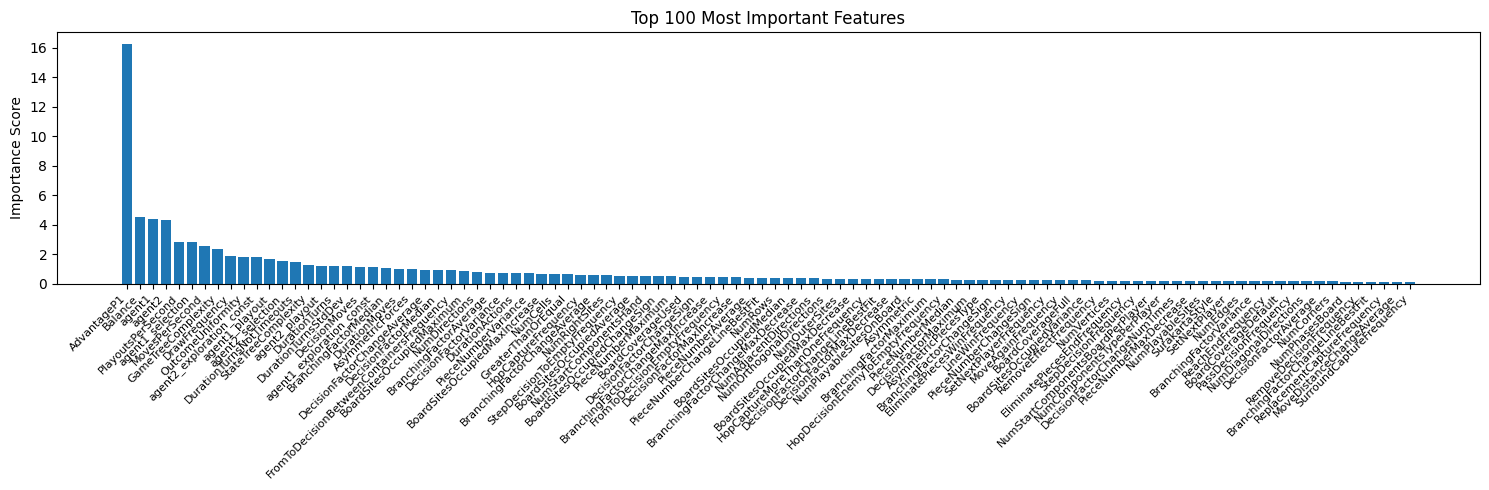

Fold 3 - RMSE: 0.42279010371315273
Fold 4


0:	learn: 0.6048408	test: 0.5901843	best: 0.5901843 (0)	total: 91.5ms	remaining: 4m 34s


50:	learn: 0.3896942	test: 0.4807267	best: 0.4807117 (49)	total: 5.53s	remaining: 5m 19s


100:	learn: 0.3514850	test: 0.4621864	best: 0.4621864 (100)	total: 11.3s	remaining: 5m 25s


150:	learn: 0.3289541	test: 0.4541189	best: 0.4541189 (150)	total: 17.1s	remaining: 5m 22s


200:	learn: 0.3119841	test: 0.4483169	best: 0.4483169 (200)	total: 22.9s	remaining: 5m 18s


250:	learn: 0.2983610	test: 0.4448488	best: 0.4448227 (249)	total: 28.6s	remaining: 5m 13s


300:	learn: 0.2879306	test: 0.4427379	best: 0.4427379 (300)	total: 34.4s	remaining: 5m 8s


350:	learn: 0.2798927	test: 0.4408826	best: 0.4408826 (350)	total: 40.3s	remaining: 5m 3s


400:	learn: 0.2726166	test: 0.4400669	best: 0.4399262 (394)	total: 46.2s	remaining: 4m 59s


450:	learn: 0.2661973	test: 0.4390131	best: 0.4390080 (449)	total: 52.1s	remaining: 4m 54s


500:	learn: 0.2605459	test: 0.4381062	best: 0.4380980 (499)	total: 57.9s	remaining: 4m 48s


550:	learn: 0.2558522	test: 0.4375158	best: 0.4375158 (550)	total: 1m 3s	remaining: 4m 44s


600:	learn: 0.2516492	test: 0.4369781	best: 0.4369352 (590)	total: 1m 9s	remaining: 4m 38s


650:	learn: 0.2478629	test: 0.4366703	best: 0.4366703 (650)	total: 1m 15s	remaining: 4m 33s


700:	learn: 0.2437710	test: 0.4362156	best: 0.4362156 (700)	total: 1m 21s	remaining: 4m 28s


750:	learn: 0.2397082	test: 0.4357537	best: 0.4357397 (748)	total: 1m 27s	remaining: 4m 22s


800:	learn: 0.2365402	test: 0.4353427	best: 0.4353427 (800)	total: 1m 33s	remaining: 4m 17s


850:	learn: 0.2335121	test: 0.4349656	best: 0.4349612 (849)	total: 1m 40s	remaining: 4m 12s


900:	learn: 0.2306511	test: 0.4347677	best: 0.4347467 (898)	total: 1m 46s	remaining: 4m 7s


950:	learn: 0.2281746	test: 0.4344956	best: 0.4344956 (950)	total: 1m 52s	remaining: 4m 1s


1000:	learn: 0.2251563	test: 0.4342222	best: 0.4342222 (1000)	total: 1m 58s	remaining: 3m 56s


1050:	learn: 0.2226055	test: 0.4340881	best: 0.4340756 (1033)	total: 2m 4s	remaining: 3m 50s


1100:	learn: 0.2200989	test: 0.4339542	best: 0.4339451 (1095)	total: 2m 10s	remaining: 3m 44s


1150:	learn: 0.2177674	test: 0.4339611	best: 0.4339329 (1121)	total: 2m 16s	remaining: 3m 39s


1200:	learn: 0.2157099	test: 0.4337711	best: 0.4337711 (1200)	total: 2m 22s	remaining: 3m 33s


1250:	learn: 0.2136059	test: 0.4337704	best: 0.4336929 (1229)	total: 2m 28s	remaining: 3m 28s


1300:	learn: 0.2114345	test: 0.4337274	best: 0.4336929 (1229)	total: 2m 35s	remaining: 3m 22s


1350:	learn: 0.2095033	test: 0.4336380	best: 0.4336004 (1343)	total: 2m 41s	remaining: 3m 16s


1400:	learn: 0.2077542	test: 0.4336429	best: 0.4335878 (1375)	total: 2m 47s	remaining: 3m 11s


1450:	learn: 0.2059564	test: 0.4336534	best: 0.4335878 (1375)	total: 2m 53s	remaining: 3m 5s


1500:	learn: 0.2038919	test: 0.4334775	best: 0.4334748 (1499)	total: 2m 59s	remaining: 2m 59s


1550:	learn: 0.2019857	test: 0.4333451	best: 0.4333092 (1533)	total: 3m 6s	remaining: 2m 53s


1600:	learn: 0.2001300	test: 0.4333224	best: 0.4333084 (1586)	total: 3m 12s	remaining: 2m 48s


1650:	learn: 0.1983028	test: 0.4333549	best: 0.4332820 (1611)	total: 3m 18s	remaining: 2m 42s


1700:	learn: 0.1967003	test: 0.4333050	best: 0.4332820 (1611)	total: 3m 25s	remaining: 2m 36s


1750:	learn: 0.1948246	test: 0.4333005	best: 0.4332703 (1713)	total: 3m 31s	remaining: 2m 30s


1800:	learn: 0.1931862	test: 0.4332264	best: 0.4332243 (1797)	total: 3m 37s	remaining: 2m 24s


1850:	learn: 0.1917274	test: 0.4331540	best: 0.4330985 (1848)	total: 3m 43s	remaining: 2m 18s


1900:	learn: 0.1903055	test: 0.4331090	best: 0.4330856 (1884)	total: 3m 50s	remaining: 2m 12s


1950:	learn: 0.1887922	test: 0.4330766	best: 0.4330750 (1948)	total: 3m 56s	remaining: 2m 7s


2000:	learn: 0.1872744	test: 0.4329935	best: 0.4329935 (2000)	total: 4m 2s	remaining: 2m 1s


2050:	learn: 0.1855979	test: 0.4329016	best: 0.4328795 (2043)	total: 4m 8s	remaining: 1m 55s


2100:	learn: 0.1842640	test: 0.4329167	best: 0.4328795 (2043)	total: 4m 15s	remaining: 1m 49s


2150:	learn: 0.1827260	test: 0.4329922	best: 0.4328795 (2043)	total: 4m 21s	remaining: 1m 43s


2200:	learn: 0.1812660	test: 0.4328497	best: 0.4328497 (2200)	total: 4m 27s	remaining: 1m 37s


2250:	learn: 0.1797079	test: 0.4328217	best: 0.4328023 (2241)	total: 4m 33s	remaining: 1m 31s


2300:	learn: 0.1785925	test: 0.4327708	best: 0.4327686 (2296)	total: 4m 40s	remaining: 1m 25s


2350:	learn: 0.1772825	test: 0.4328282	best: 0.4327686 (2296)	total: 4m 46s	remaining: 1m 19s


2400:	learn: 0.1759694	test: 0.4327826	best: 0.4327686 (2296)	total: 4m 52s	remaining: 1m 13s


2450:	learn: 0.1748009	test: 0.4328429	best: 0.4327686 (2296)	total: 4m 59s	remaining: 1m 6s


2500:	learn: 0.1734890	test: 0.4328040	best: 0.4327686 (2296)	total: 5m 5s	remaining: 1m


2550:	learn: 0.1723058	test: 0.4326363	best: 0.4326329 (2549)	total: 5m 11s	remaining: 54.8s


2600:	learn: 0.1710631	test: 0.4326789	best: 0.4326329 (2549)	total: 5m 17s	remaining: 48.7s


2650:	learn: 0.1699239	test: 0.4326764	best: 0.4326329 (2549)	total: 5m 24s	remaining: 42.7s


2700:	learn: 0.1686342	test: 0.4325976	best: 0.4325948 (2699)	total: 5m 30s	remaining: 36.6s


2750:	learn: 0.1674707	test: 0.4325408	best: 0.4325408 (2750)	total: 5m 36s	remaining: 30.4s


2800:	learn: 0.1663251	test: 0.4324989	best: 0.4324807 (2781)	total: 5m 42s	remaining: 24.3s


2850:	learn: 0.1651204	test: 0.4324590	best: 0.4324587 (2849)	total: 5m 48s	remaining: 18.2s


2900:	learn: 0.1640032	test: 0.4325113	best: 0.4324298 (2858)	total: 5m 54s	remaining: 12.1s


2950:	learn: 0.1628384	test: 0.4326265	best: 0.4324298 (2858)	total: 6m 1s	remaining: 6s


2999:	learn: 0.1616206	test: 0.4325765	best: 0.4324298 (2858)	total: 6m 7s	remaining: 0us

bestTest = 0.4324298207
bestIteration = 2858

Shrink model to first 2859 iterations.


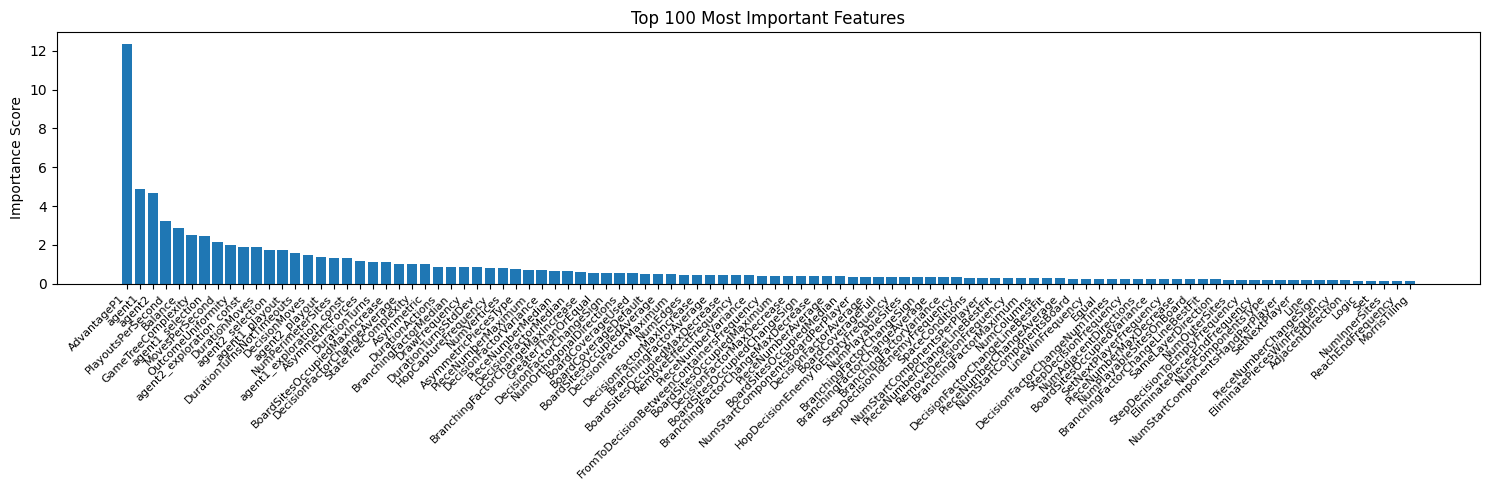

Fold 4 - RMSE: 0.43181181568017174
Fold 5


0:	learn: 0.6164767	test: 0.5407268	best: 0.5407268 (0)	total: 95.4ms	remaining: 4m 46s


50:	learn: 0.3959692	test: 0.4430259	best: 0.4430259 (50)	total: 5.95s	remaining: 5m 43s


100:	learn: 0.3582178	test: 0.4252781	best: 0.4252781 (100)	total: 12.1s	remaining: 5m 47s


150:	learn: 0.3355035	test: 0.4188753	best: 0.4188726 (149)	total: 18.4s	remaining: 5m 46s


200:	learn: 0.3209721	test: 0.4134704	best: 0.4134514 (199)	total: 24.6s	remaining: 5m 42s


250:	learn: 0.3086200	test: 0.4113320	best: 0.4113320 (250)	total: 30.8s	remaining: 5m 36s


300:	learn: 0.2989702	test: 0.4095807	best: 0.4095628 (299)	total: 37s	remaining: 5m 31s


350:	learn: 0.2905627	test: 0.4073638	best: 0.4073638 (350)	total: 43.1s	remaining: 5m 25s


400:	learn: 0.2834285	test: 0.4059780	best: 0.4059415 (394)	total: 49.4s	remaining: 5m 20s


450:	learn: 0.2774011	test: 0.4050056	best: 0.4050056 (450)	total: 55.6s	remaining: 5m 14s


500:	learn: 0.2722603	test: 0.4042850	best: 0.4042850 (500)	total: 1m 1s	remaining: 5m 8s


550:	learn: 0.2673727	test: 0.4038345	best: 0.4038325 (549)	total: 1m 8s	remaining: 5m 3s


600:	learn: 0.2622404	test: 0.4025539	best: 0.4025539 (600)	total: 1m 14s	remaining: 4m 56s


650:	learn: 0.2577110	test: 0.4025030	best: 0.4025030 (650)	total: 1m 20s	remaining: 4m 51s


700:	learn: 0.2535426	test: 0.4021946	best: 0.4021946 (700)	total: 1m 26s	remaining: 4m 44s


750:	learn: 0.2496045	test: 0.4020148	best: 0.4019680 (738)	total: 1m 33s	remaining: 4m 38s


800:	learn: 0.2466949	test: 0.4015966	best: 0.4015733 (792)	total: 1m 39s	remaining: 4m 33s


850:	learn: 0.2432216	test: 0.4013020	best: 0.4012933 (838)	total: 1m 45s	remaining: 4m 27s


900:	learn: 0.2398369	test: 0.4009926	best: 0.4009926 (900)	total: 1m 51s	remaining: 4m 20s


950:	learn: 0.2370263	test: 0.4008715	best: 0.4007881 (943)	total: 1m 58s	remaining: 4m 14s


1000:	learn: 0.2341847	test: 0.4006588	best: 0.4006588 (1000)	total: 2m 4s	remaining: 4m 8s


1050:	learn: 0.2314686	test: 0.4004275	best: 0.4003651 (1041)	total: 2m 10s	remaining: 4m 2s


1100:	learn: 0.2288895	test: 0.4004363	best: 0.4003651 (1041)	total: 2m 17s	remaining: 3m 56s


1150:	learn: 0.2263227	test: 0.4001888	best: 0.4001710 (1143)	total: 2m 23s	remaining: 3m 50s


1200:	learn: 0.2238218	test: 0.4002231	best: 0.4001334 (1176)	total: 2m 29s	remaining: 3m 44s


1250:	learn: 0.2214738	test: 0.4001174	best: 0.4000735 (1228)	total: 2m 36s	remaining: 3m 38s


1300:	learn: 0.2188978	test: 0.3999449	best: 0.3999431 (1297)	total: 2m 42s	remaining: 3m 31s


1350:	learn: 0.2167993	test: 0.3997417	best: 0.3997417 (1350)	total: 2m 48s	remaining: 3m 25s


1400:	learn: 0.2148702	test: 0.3996893	best: 0.3996893 (1400)	total: 2m 54s	remaining: 3m 19s


1450:	learn: 0.2129038	test: 0.3996458	best: 0.3995749 (1416)	total: 3m 1s	remaining: 3m 13s


1500:	learn: 0.2108191	test: 0.3997785	best: 0.3995749 (1416)	total: 3m 7s	remaining: 3m 7s


1550:	learn: 0.2086120	test: 0.3996985	best: 0.3995749 (1416)	total: 3m 13s	remaining: 3m 1s


1600:	learn: 0.2066815	test: 0.3996171	best: 0.3995749 (1416)	total: 3m 20s	remaining: 2m 54s


1650:	learn: 0.2047269	test: 0.3994959	best: 0.3994959 (1650)	total: 3m 26s	remaining: 2m 48s


1700:	learn: 0.2027640	test: 0.3994577	best: 0.3994006 (1677)	total: 3m 32s	remaining: 2m 42s


1750:	learn: 0.2011164	test: 0.3993859	best: 0.3993839 (1749)	total: 3m 39s	remaining: 2m 36s


1800:	learn: 0.1993208	test: 0.3992180	best: 0.3992103 (1781)	total: 3m 45s	remaining: 2m 30s


1850:	learn: 0.1978332	test: 0.3991497	best: 0.3991350 (1848)	total: 3m 51s	remaining: 2m 23s


1900:	learn: 0.1962737	test: 0.3990956	best: 0.3990616 (1899)	total: 3m 58s	remaining: 2m 17s


1950:	learn: 0.1948116	test: 0.3991102	best: 0.3990581 (1934)	total: 4m 4s	remaining: 2m 11s


2000:	learn: 0.1932235	test: 0.3991085	best: 0.3990581 (1934)	total: 4m 10s	remaining: 2m 5s


2050:	learn: 0.1916120	test: 0.3991269	best: 0.3990581 (1934)	total: 4m 17s	remaining: 1m 58s


2100:	learn: 0.1900286	test: 0.3990952	best: 0.3990581 (1934)	total: 4m 23s	remaining: 1m 52s


2150:	learn: 0.1886366	test: 0.3990562	best: 0.3990557 (2149)	total: 4m 29s	remaining: 1m 46s


2200:	learn: 0.1872763	test: 0.3991165	best: 0.3990557 (2149)	total: 4m 36s	remaining: 1m 40s


2250:	learn: 0.1858063	test: 0.3990802	best: 0.3990557 (2149)	total: 4m 42s	remaining: 1m 34s


2300:	learn: 0.1843254	test: 0.3991002	best: 0.3990534 (2273)	total: 4m 49s	remaining: 1m 27s


2350:	learn: 0.1828992	test: 0.3990450	best: 0.3990363 (2324)	total: 4m 55s	remaining: 1m 21s


2400:	learn: 0.1815633	test: 0.3989930	best: 0.3989895 (2396)	total: 5m 2s	remaining: 1m 15s


2450:	learn: 0.1799793	test: 0.3989932	best: 0.3989465 (2415)	total: 5m 8s	remaining: 1m 9s


2500:	learn: 0.1786207	test: 0.3989002	best: 0.3988730 (2497)	total: 5m 14s	remaining: 1m 2s


2550:	learn: 0.1772086	test: 0.3988384	best: 0.3988384 (2550)	total: 5m 21s	remaining: 56.5s


2600:	learn: 0.1759965	test: 0.3988425	best: 0.3987961 (2565)	total: 5m 27s	remaining: 50.3s


2650:	learn: 0.1747675	test: 0.3987886	best: 0.3987886 (2650)	total: 5m 34s	remaining: 44s


2700:	learn: 0.1736220	test: 0.3988130	best: 0.3987756 (2671)	total: 5m 40s	remaining: 37.7s


2750:	learn: 0.1724622	test: 0.3987996	best: 0.3987668 (2737)	total: 5m 47s	remaining: 31.4s


2800:	learn: 0.1713350	test: 0.3987926	best: 0.3987668 (2737)	total: 5m 53s	remaining: 25.1s


2850:	learn: 0.1702280	test: 0.3988410	best: 0.3987668 (2737)	total: 5m 59s	remaining: 18.8s


2900:	learn: 0.1690546	test: 0.3987818	best: 0.3987668 (2737)	total: 6m 6s	remaining: 12.5s


2950:	learn: 0.1681053	test: 0.3988108	best: 0.3987668 (2737)	total: 6m 12s	remaining: 6.19s


2999:	learn: 0.1669690	test: 0.3987586	best: 0.3987571 (2998)	total: 6m 19s	remaining: 0us

bestTest = 0.3987571299
bestIteration = 2998

Shrink model to first 2999 iterations.


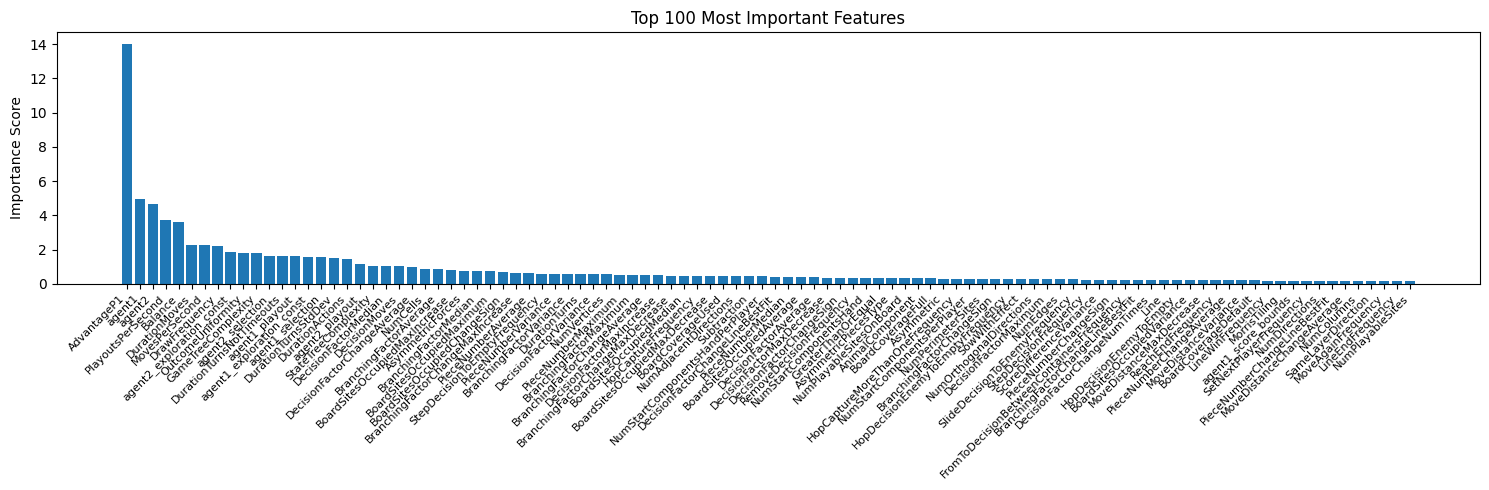

Fold 5 - RMSE: 0.39825344181531525
List of oof scores: [0.41473341825229054, 0.4370922255959416, 0.42279010371315273, 0.43181181568017174, 0.39825344181531525]
Average oof score: 0.4209362010113744


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6155928	test: 0.5304045	best: 0.5304045 (0)	total: 97.6ms	remaining: 4m 52s


50:	learn: 0.3910216	test: 0.4508086	best: 0.4508086 (50)	total: 5.97s	remaining: 5m 44s


100:	learn: 0.3521835	test: 0.4366538	best: 0.4365461 (98)	total: 12.1s	remaining: 5m 46s


150:	learn: 0.3289682	test: 0.4304387	best: 0.4304387 (150)	total: 18.1s	remaining: 5m 40s


200:	learn: 0.3129205	test: 0.4267585	best: 0.4267199 (199)	total: 24.2s	remaining: 5m 36s


250:	learn: 0.3004493	test: 0.4245946	best: 0.4245946 (250)	total: 30.2s	remaining: 5m 31s


300:	learn: 0.2904055	test: 0.4222780	best: 0.4222780 (300)	total: 36.3s	remaining: 5m 25s


350:	learn: 0.2818981	test: 0.4215078	best: 0.4214940 (348)	total: 42.5s	remaining: 5m 21s


400:	learn: 0.2747065	test: 0.4205161	best: 0.4205161 (400)	total: 48.7s	remaining: 5m 15s


450:	learn: 0.2679949	test: 0.4194248	best: 0.4194248 (450)	total: 54.7s	remaining: 5m 9s


500:	learn: 0.2626740	test: 0.4187603	best: 0.4187442 (494)	total: 1m	remaining: 5m 2s


550:	learn: 0.2569897	test: 0.4181020	best: 0.4180715 (549)	total: 1m 6s	remaining: 4m 57s


600:	learn: 0.2518918	test: 0.4173134	best: 0.4173134 (600)	total: 1m 12s	remaining: 4m 51s


650:	learn: 0.2474514	test: 0.4167273	best: 0.4167273 (650)	total: 1m 18s	remaining: 4m 44s


700:	learn: 0.2437670	test: 0.4164265	best: 0.4164265 (700)	total: 1m 25s	remaining: 4m 39s


750:	learn: 0.2405666	test: 0.4163225	best: 0.4162038 (725)	total: 1m 31s	remaining: 4m 33s


800:	learn: 0.2372165	test: 0.4159212	best: 0.4159212 (800)	total: 1m 37s	remaining: 4m 27s


850:	learn: 0.2339628	test: 0.4155620	best: 0.4155429 (848)	total: 1m 43s	remaining: 4m 21s


900:	learn: 0.2309605	test: 0.4151757	best: 0.4151160 (899)	total: 1m 49s	remaining: 4m 15s


950:	learn: 0.2281004	test: 0.4148431	best: 0.4148385 (949)	total: 1m 55s	remaining: 4m 9s


1000:	learn: 0.2254562	test: 0.4148121	best: 0.4148109 (995)	total: 2m 1s	remaining: 4m 3s


1050:	learn: 0.2226353	test: 0.4144795	best: 0.4144724 (1048)	total: 2m 7s	remaining: 3m 57s


1100:	learn: 0.2201915	test: 0.4143600	best: 0.4143135 (1090)	total: 2m 14s	remaining: 3m 51s


1150:	learn: 0.2178889	test: 0.4143404	best: 0.4142612 (1140)	total: 2m 20s	remaining: 3m 45s


1200:	learn: 0.2155485	test: 0.4142028	best: 0.4142002 (1195)	total: 2m 26s	remaining: 3m 39s


1250:	learn: 0.2133107	test: 0.4142685	best: 0.4141881 (1202)	total: 2m 32s	remaining: 3m 33s


1300:	learn: 0.2109279	test: 0.4141329	best: 0.4141328 (1298)	total: 2m 38s	remaining: 3m 26s


1350:	learn: 0.2091221	test: 0.4141516	best: 0.4140834 (1335)	total: 2m 44s	remaining: 3m 20s


1400:	learn: 0.2069803	test: 0.4141494	best: 0.4140834 (1335)	total: 2m 50s	remaining: 3m 14s


1450:	learn: 0.2048790	test: 0.4139367	best: 0.4139297 (1438)	total: 2m 56s	remaining: 3m 8s


1500:	learn: 0.2029844	test: 0.4139208	best: 0.4139208 (1500)	total: 3m 2s	remaining: 3m 2s


1550:	learn: 0.2009643	test: 0.4138149	best: 0.4138149 (1550)	total: 3m 8s	remaining: 2m 56s


1600:	learn: 0.1992413	test: 0.4137694	best: 0.4137691 (1557)	total: 3m 15s	remaining: 2m 50s


1650:	learn: 0.1974731	test: 0.4137477	best: 0.4136676 (1630)	total: 3m 21s	remaining: 2m 44s


1700:	learn: 0.1960004	test: 0.4137590	best: 0.4136676 (1630)	total: 3m 27s	remaining: 2m 38s


1750:	learn: 0.1940701	test: 0.4137656	best: 0.4136676 (1630)	total: 3m 33s	remaining: 2m 32s


1800:	learn: 0.1920891	test: 0.4135979	best: 0.4135913 (1799)	total: 3m 39s	remaining: 2m 26s


1850:	learn: 0.1905699	test: 0.4135854	best: 0.4135434 (1835)	total: 3m 45s	remaining: 2m 20s


1900:	learn: 0.1891354	test: 0.4135563	best: 0.4135434 (1835)	total: 3m 51s	remaining: 2m 14s


1950:	learn: 0.1871899	test: 0.4134971	best: 0.4134614 (1929)	total: 3m 58s	remaining: 2m 8s


2000:	learn: 0.1855117	test: 0.4135292	best: 0.4134614 (1929)	total: 4m 4s	remaining: 2m 1s


2050:	learn: 0.1841816	test: 0.4135015	best: 0.4134614 (1929)	total: 4m 10s	remaining: 1m 55s


2100:	learn: 0.1829081	test: 0.4134965	best: 0.4134614 (1929)	total: 4m 16s	remaining: 1m 49s


2150:	learn: 0.1812419	test: 0.4133742	best: 0.4133742 (2150)	total: 4m 23s	remaining: 1m 43s


2200:	learn: 0.1799797	test: 0.4134298	best: 0.4133734 (2154)	total: 4m 29s	remaining: 1m 37s


2250:	learn: 0.1785723	test: 0.4133926	best: 0.4133734 (2154)	total: 4m 35s	remaining: 1m 31s


2300:	learn: 0.1774233	test: 0.4133823	best: 0.4133716 (2296)	total: 4m 41s	remaining: 1m 25s


2350:	learn: 0.1757886	test: 0.4134591	best: 0.4133716 (2296)	total: 4m 47s	remaining: 1m 19s


2400:	learn: 0.1744891	test: 0.4134064	best: 0.4133716 (2296)	total: 4m 53s	remaining: 1m 13s


2450:	learn: 0.1730452	test: 0.4133839	best: 0.4133667 (2435)	total: 5m	remaining: 1m 7s


2500:	learn: 0.1719310	test: 0.4134544	best: 0.4133667 (2435)	total: 5m 6s	remaining: 1m 1s


2550:	learn: 0.1706723	test: 0.4134291	best: 0.4133667 (2435)	total: 5m 12s	remaining: 55s


2600:	learn: 0.1694542	test: 0.4134320	best: 0.4133667 (2435)	total: 5m 18s	remaining: 48.9s


2650:	learn: 0.1683540	test: 0.4133994	best: 0.4133667 (2435)	total: 5m 24s	remaining: 42.8s


2700:	learn: 0.1669106	test: 0.4133853	best: 0.4133650 (2693)	total: 5m 31s	remaining: 36.7s


2750:	learn: 0.1656759	test: 0.4133495	best: 0.4133426 (2734)	total: 5m 37s	remaining: 30.5s


2800:	learn: 0.1644414	test: 0.4133005	best: 0.4132883 (2794)	total: 5m 43s	remaining: 24.4s


2850:	learn: 0.1632020	test: 0.4132339	best: 0.4132339 (2850)	total: 5m 49s	remaining: 18.3s


2900:	learn: 0.1622010	test: 0.4132613	best: 0.4132279 (2853)	total: 5m 55s	remaining: 12.1s


2950:	learn: 0.1610316	test: 0.4132827	best: 0.4132279 (2853)	total: 6m 1s	remaining: 6.01s


2999:	learn: 0.1600357	test: 0.4132816	best: 0.4132279 (2853)	total: 6m 8s	remaining: 0us

bestTest = 0.4132279499
bestIteration = 2853

Shrink model to first 2854 iterations.


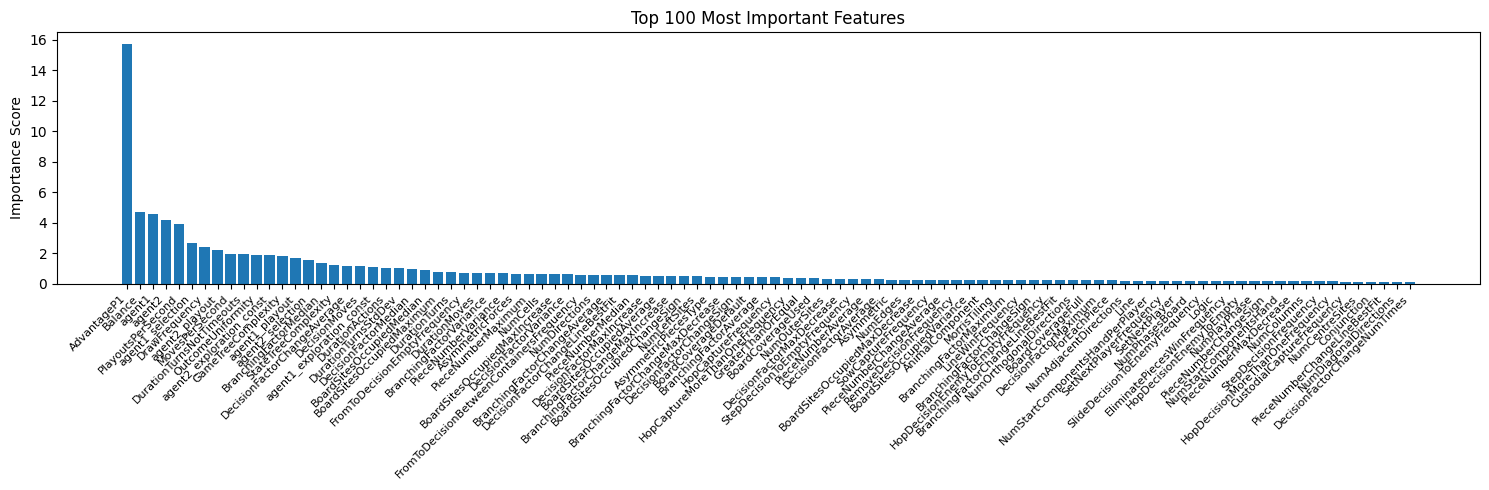

Fold 1 - RMSE: 0.4129239733401865
Fold 2


0:	learn: 0.6141148	test: 0.5372619	best: 0.5372619 (0)	total: 104ms	remaining: 5m 12s


50:	learn: 0.3888052	test: 0.4259101	best: 0.4259101 (50)	total: 5.93s	remaining: 5m 42s


100:	learn: 0.3477284	test: 0.4140610	best: 0.4140610 (100)	total: 12.1s	remaining: 5m 46s


150:	learn: 0.3263733	test: 0.4082685	best: 0.4082685 (150)	total: 18.3s	remaining: 5m 45s


200:	learn: 0.3118431	test: 0.4058544	best: 0.4058399 (199)	total: 24.6s	remaining: 5m 42s


250:	learn: 0.2993983	test: 0.4043611	best: 0.4043611 (250)	total: 30.8s	remaining: 5m 37s


300:	learn: 0.2884440	test: 0.4031434	best: 0.4029723 (294)	total: 37s	remaining: 5m 32s


350:	learn: 0.2809935	test: 0.4025430	best: 0.4025430 (350)	total: 43.2s	remaining: 5m 26s


400:	learn: 0.2731342	test: 0.4018255	best: 0.4017611 (385)	total: 49.4s	remaining: 5m 20s


450:	learn: 0.2671213	test: 0.4016508	best: 0.4015096 (444)	total: 55.6s	remaining: 5m 14s


500:	learn: 0.2618530	test: 0.4015261	best: 0.4015096 (444)	total: 1m 1s	remaining: 5m 8s


550:	learn: 0.2570063	test: 0.4009224	best: 0.4009147 (549)	total: 1m 8s	remaining: 5m 2s


600:	learn: 0.2524704	test: 0.4006600	best: 0.4006600 (600)	total: 1m 14s	remaining: 4m 56s


650:	learn: 0.2485489	test: 0.4005005	best: 0.4005004 (647)	total: 1m 20s	remaining: 4m 50s


700:	learn: 0.2446924	test: 0.4002509	best: 0.4001703 (694)	total: 1m 26s	remaining: 4m 44s


750:	learn: 0.2407039	test: 0.4000058	best: 0.3999820 (743)	total: 1m 32s	remaining: 4m 38s


800:	learn: 0.2376667	test: 0.3997188	best: 0.3997188 (800)	total: 1m 39s	remaining: 4m 32s


850:	learn: 0.2346043	test: 0.3996732	best: 0.3996732 (850)	total: 1m 45s	remaining: 4m 26s


900:	learn: 0.2318036	test: 0.3997108	best: 0.3996732 (850)	total: 1m 51s	remaining: 4m 20s


950:	learn: 0.2287974	test: 0.3996381	best: 0.3995985 (920)	total: 1m 57s	remaining: 4m 14s


1000:	learn: 0.2259913	test: 0.3997727	best: 0.3995985 (920)	total: 2m 4s	remaining: 4m 7s


1050:	learn: 0.2234389	test: 0.3996630	best: 0.3995985 (920)	total: 2m 10s	remaining: 4m 1s


1100:	learn: 0.2208812	test: 0.3995891	best: 0.3995693 (1094)	total: 2m 16s	remaining: 3m 55s


1150:	learn: 0.2188909	test: 0.3996257	best: 0.3995693 (1094)	total: 2m 23s	remaining: 3m 49s


1200:	learn: 0.2163680	test: 0.3994615	best: 0.3994553 (1191)	total: 2m 29s	remaining: 3m 43s


1250:	learn: 0.2141385	test: 0.3993714	best: 0.3993589 (1248)	total: 2m 35s	remaining: 3m 37s


1300:	learn: 0.2118841	test: 0.3992865	best: 0.3992777 (1281)	total: 2m 41s	remaining: 3m 31s


1350:	learn: 0.2096477	test: 0.3992454	best: 0.3992445 (1348)	total: 2m 48s	remaining: 3m 25s


1400:	learn: 0.2073045	test: 0.3994043	best: 0.3992310 (1351)	total: 2m 54s	remaining: 3m 19s


1450:	learn: 0.2055109	test: 0.3994797	best: 0.3992310 (1351)	total: 3m	remaining: 3m 12s


1500:	learn: 0.2034131	test: 0.3995049	best: 0.3992310 (1351)	total: 3m 6s	remaining: 3m 6s


1550:	learn: 0.2013992	test: 0.3994724	best: 0.3992310 (1351)	total: 3m 13s	remaining: 3m


1600:	learn: 0.1995421	test: 0.3995474	best: 0.3992310 (1351)	total: 3m 19s	remaining: 2m 54s


1650:	learn: 0.1977832	test: 0.3995529	best: 0.3992310 (1351)	total: 3m 25s	remaining: 2m 48s


1700:	learn: 0.1959766	test: 0.3996565	best: 0.3992310 (1351)	total: 3m 32s	remaining: 2m 42s


1750:	learn: 0.1941528	test: 0.3996050	best: 0.3992310 (1351)	total: 3m 38s	remaining: 2m 35s


1800:	learn: 0.1925489	test: 0.3996016	best: 0.3992310 (1351)	total: 3m 44s	remaining: 2m 29s


1850:	learn: 0.1908697	test: 0.3996189	best: 0.3992310 (1351)	total: 3m 51s	remaining: 2m 23s


1900:	learn: 0.1894220	test: 0.3996378	best: 0.3992310 (1351)	total: 3m 57s	remaining: 2m 17s


1950:	learn: 0.1880599	test: 0.3995261	best: 0.3992310 (1351)	total: 4m 3s	remaining: 2m 11s


2000:	learn: 0.1863948	test: 0.3995447	best: 0.3992310 (1351)	total: 4m 10s	remaining: 2m 4s


2050:	learn: 0.1848839	test: 0.3995263	best: 0.3992310 (1351)	total: 4m 16s	remaining: 1m 58s


2100:	learn: 0.1834407	test: 0.3995343	best: 0.3992310 (1351)	total: 4m 23s	remaining: 1m 52s


2150:	learn: 0.1819019	test: 0.3994225	best: 0.3992310 (1351)	total: 4m 29s	remaining: 1m 46s


2200:	learn: 0.1802356	test: 0.3994172	best: 0.3992310 (1351)	total: 4m 35s	remaining: 1m 40s


2250:	learn: 0.1786265	test: 0.3994705	best: 0.3992310 (1351)	total: 4m 41s	remaining: 1m 33s


2300:	learn: 0.1772073	test: 0.3994248	best: 0.3992310 (1351)	total: 4m 48s	remaining: 1m 27s


2350:	learn: 0.1758874	test: 0.3994216	best: 0.3992310 (1351)	total: 4m 54s	remaining: 1m 21s


2400:	learn: 0.1745938	test: 0.3993776	best: 0.3992310 (1351)	total: 5m	remaining: 1m 15s


2450:	learn: 0.1733389	test: 0.3993714	best: 0.3992310 (1351)	total: 5m 7s	remaining: 1m 8s


2500:	learn: 0.1721750	test: 0.3993167	best: 0.3992310 (1351)	total: 5m 13s	remaining: 1m 2s


2550:	learn: 0.1708477	test: 0.3993099	best: 0.3992310 (1351)	total: 5m 19s	remaining: 56.3s


2600:	learn: 0.1697034	test: 0.3993127	best: 0.3992310 (1351)	total: 5m 25s	remaining: 50s


2650:	learn: 0.1683518	test: 0.3993332	best: 0.3992310 (1351)	total: 5m 32s	remaining: 43.7s


2700:	learn: 0.1669766	test: 0.3993283	best: 0.3992310 (1351)	total: 5m 38s	remaining: 37.5s


2750:	learn: 0.1656305	test: 0.3992946	best: 0.3992310 (1351)	total: 5m 44s	remaining: 31.2s


2800:	learn: 0.1644024	test: 0.3993215	best: 0.3992310 (1351)	total: 5m 50s	remaining: 24.9s


2850:	learn: 0.1633853	test: 0.3994255	best: 0.3992310 (1351)	total: 5m 57s	remaining: 18.7s


2900:	learn: 0.1622211	test: 0.3994923	best: 0.3992310 (1351)	total: 6m 3s	remaining: 12.4s


2950:	learn: 0.1610232	test: 0.3995257	best: 0.3992310 (1351)	total: 6m 9s	remaining: 6.14s


2999:	learn: 0.1600830	test: 0.3995261	best: 0.3992310 (1351)	total: 6m 16s	remaining: 0us

bestTest = 0.3992310131
bestIteration = 1351

Shrink model to first 1352 iterations.


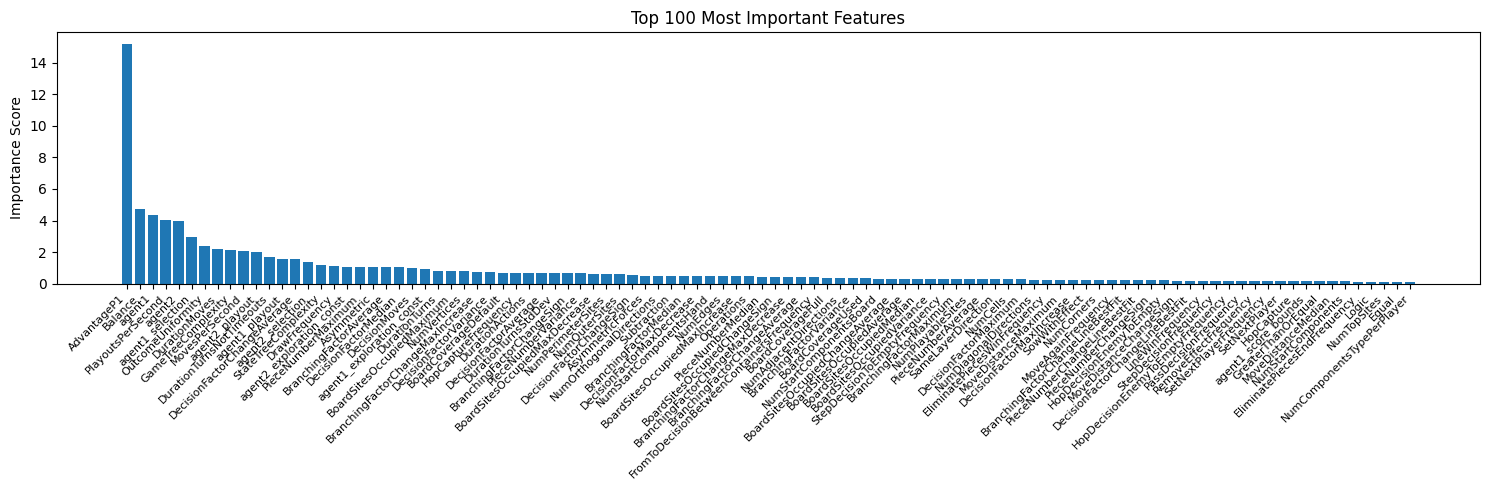

Fold 2 - RMSE: 0.3985645204661043
Fold 3


0:	learn: 0.6017275	test: 0.6078907	best: 0.6078907 (0)	total: 128ms	remaining: 6m 24s


50:	learn: 0.3837657	test: 0.4829136	best: 0.4829136 (50)	total: 6.21s	remaining: 5m 59s


100:	learn: 0.3473961	test: 0.4622938	best: 0.4622938 (100)	total: 12.7s	remaining: 6m 5s


150:	learn: 0.3259890	test: 0.4522665	best: 0.4522665 (150)	total: 19.1s	remaining: 5m 59s


200:	learn: 0.3091052	test: 0.4462816	best: 0.4462816 (200)	total: 25.3s	remaining: 5m 52s


250:	learn: 0.2973733	test: 0.4418114	best: 0.4418114 (250)	total: 31.6s	remaining: 5m 45s


300:	learn: 0.2874131	test: 0.4390092	best: 0.4389846 (299)	total: 38s	remaining: 5m 41s


350:	learn: 0.2796268	test: 0.4370969	best: 0.4370969 (350)	total: 44.5s	remaining: 5m 35s


400:	learn: 0.2727031	test: 0.4359494	best: 0.4359366 (399)	total: 50.9s	remaining: 5m 30s


450:	learn: 0.2669401	test: 0.4352102	best: 0.4351960 (449)	total: 57.4s	remaining: 5m 24s


500:	learn: 0.2612341	test: 0.4340977	best: 0.4340977 (500)	total: 1m 3s	remaining: 5m 18s


550:	learn: 0.2556965	test: 0.4337279	best: 0.4337263 (544)	total: 1m 10s	remaining: 5m 12s


600:	learn: 0.2509162	test: 0.4329950	best: 0.4329296 (594)	total: 1m 16s	remaining: 5m 6s


650:	learn: 0.2465670	test: 0.4326585	best: 0.4326585 (650)	total: 1m 23s	remaining: 5m


700:	learn: 0.2428054	test: 0.4320186	best: 0.4320186 (700)	total: 1m 29s	remaining: 4m 54s


750:	learn: 0.2393059	test: 0.4313729	best: 0.4313690 (749)	total: 1m 36s	remaining: 4m 47s


800:	learn: 0.2356029	test: 0.4308866	best: 0.4308866 (800)	total: 1m 42s	remaining: 4m 41s


850:	learn: 0.2325309	test: 0.4304900	best: 0.4304885 (842)	total: 1m 48s	remaining: 4m 34s


900:	learn: 0.2297811	test: 0.4300037	best: 0.4299990 (899)	total: 1m 55s	remaining: 4m 28s


950:	learn: 0.2270393	test: 0.4296344	best: 0.4296344 (950)	total: 2m 1s	remaining: 4m 22s


1000:	learn: 0.2242966	test: 0.4293752	best: 0.4293752 (1000)	total: 2m 8s	remaining: 4m 16s


1050:	learn: 0.2218601	test: 0.4291016	best: 0.4291016 (1050)	total: 2m 14s	remaining: 4m 10s


1100:	learn: 0.2195023	test: 0.4289728	best: 0.4289614 (1097)	total: 2m 21s	remaining: 4m 3s


1150:	learn: 0.2170345	test: 0.4288057	best: 0.4287953 (1140)	total: 2m 27s	remaining: 3m 57s


1200:	learn: 0.2148509	test: 0.4285764	best: 0.4285576 (1197)	total: 2m 34s	remaining: 3m 51s


1250:	learn: 0.2124124	test: 0.4284309	best: 0.4284294 (1249)	total: 2m 40s	remaining: 3m 44s


1300:	learn: 0.2103688	test: 0.4282998	best: 0.4282998 (1300)	total: 2m 47s	remaining: 3m 38s


1350:	learn: 0.2084661	test: 0.4282001	best: 0.4282001 (1350)	total: 2m 53s	remaining: 3m 32s


1400:	learn: 0.2066361	test: 0.4282317	best: 0.4281725 (1355)	total: 3m	remaining: 3m 25s


1450:	learn: 0.2048168	test: 0.4281619	best: 0.4281480 (1442)	total: 3m 6s	remaining: 3m 19s


1500:	learn: 0.2028007	test: 0.4280853	best: 0.4280853 (1500)	total: 3m 13s	remaining: 3m 13s


1550:	learn: 0.2011072	test: 0.4279770	best: 0.4279365 (1543)	total: 3m 19s	remaining: 3m 6s


1600:	learn: 0.1994692	test: 0.4277469	best: 0.4277463 (1595)	total: 3m 26s	remaining: 3m


1650:	learn: 0.1975492	test: 0.4276932	best: 0.4276779 (1630)	total: 3m 32s	remaining: 2m 53s


1700:	learn: 0.1959588	test: 0.4275809	best: 0.4275780 (1699)	total: 3m 39s	remaining: 2m 47s


1750:	learn: 0.1940410	test: 0.4274145	best: 0.4274145 (1750)	total: 3m 45s	remaining: 2m 41s


1800:	learn: 0.1926622	test: 0.4273491	best: 0.4273436 (1787)	total: 3m 52s	remaining: 2m 34s


1850:	learn: 0.1910324	test: 0.4272392	best: 0.4272342 (1840)	total: 3m 59s	remaining: 2m 28s


1900:	learn: 0.1895607	test: 0.4271826	best: 0.4271708 (1890)	total: 4m 5s	remaining: 2m 21s


1950:	learn: 0.1879858	test: 0.4270645	best: 0.4270611 (1949)	total: 4m 12s	remaining: 2m 15s


2000:	learn: 0.1864899	test: 0.4269233	best: 0.4269209 (1991)	total: 4m 18s	remaining: 2m 9s


2050:	learn: 0.1850978	test: 0.4269468	best: 0.4268735 (2037)	total: 4m 25s	remaining: 2m 2s


2100:	learn: 0.1835651	test: 0.4268926	best: 0.4268735 (2037)	total: 4m 31s	remaining: 1m 56s


2150:	learn: 0.1822368	test: 0.4268116	best: 0.4268060 (2142)	total: 4m 38s	remaining: 1m 49s


2200:	learn: 0.1806527	test: 0.4268948	best: 0.4267902 (2151)	total: 4m 44s	remaining: 1m 43s


2250:	learn: 0.1793631	test: 0.4268719	best: 0.4267902 (2151)	total: 4m 51s	remaining: 1m 36s


2300:	learn: 0.1781360	test: 0.4268419	best: 0.4267902 (2151)	total: 4m 57s	remaining: 1m 30s


2350:	learn: 0.1769506	test: 0.4268421	best: 0.4267902 (2151)	total: 5m 4s	remaining: 1m 24s


2400:	learn: 0.1756655	test: 0.4267843	best: 0.4267699 (2399)	total: 5m 10s	remaining: 1m 17s


2450:	learn: 0.1745093	test: 0.4267716	best: 0.4267688 (2448)	total: 5m 17s	remaining: 1m 11s


2500:	learn: 0.1732158	test: 0.4267892	best: 0.4267429 (2464)	total: 5m 23s	remaining: 1m 4s


2550:	learn: 0.1721026	test: 0.4266912	best: 0.4266912 (2550)	total: 5m 30s	remaining: 58.2s


2600:	learn: 0.1708043	test: 0.4267281	best: 0.4266912 (2550)	total: 5m 36s	remaining: 51.7s


2650:	learn: 0.1694538	test: 0.4266965	best: 0.4266912 (2550)	total: 5m 43s	remaining: 45.2s


2700:	learn: 0.1682742	test: 0.4267116	best: 0.4266642 (2661)	total: 5m 50s	remaining: 38.7s


2750:	learn: 0.1673294	test: 0.4266701	best: 0.4266642 (2661)	total: 5m 56s	remaining: 32.3s


2800:	learn: 0.1662986	test: 0.4266446	best: 0.4266408 (2772)	total: 6m 3s	remaining: 25.8s


2850:	learn: 0.1652015	test: 0.4266717	best: 0.4266408 (2772)	total: 6m 9s	remaining: 19.3s


2900:	learn: 0.1640906	test: 0.4266654	best: 0.4266280 (2894)	total: 6m 16s	remaining: 12.8s


2950:	learn: 0.1630578	test: 0.4266160	best: 0.4266095 (2946)	total: 6m 22s	remaining: 6.35s


2999:	learn: 0.1619800	test: 0.4266441	best: 0.4265947 (2955)	total: 6m 28s	remaining: 0us

bestTest = 0.4265946632
bestIteration = 2955

Shrink model to first 2956 iterations.


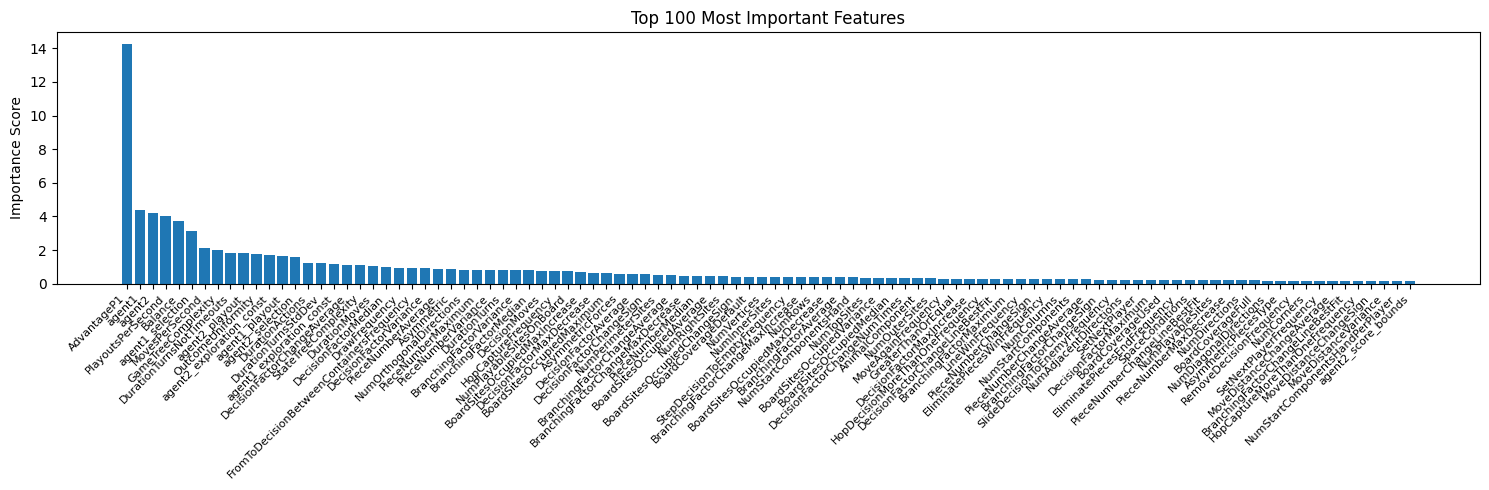

Fold 3 - RMSE: 0.42604801699126904
Fold 4


0:	learn: 0.6024952	test: 0.5976850	best: 0.5976850 (0)	total: 95.1ms	remaining: 4m 45s


50:	learn: 0.3894949	test: 0.4846031	best: 0.4846031 (50)	total: 6.05s	remaining: 5m 49s


100:	learn: 0.3545068	test: 0.4659520	best: 0.4659520 (100)	total: 12.4s	remaining: 5m 55s


150:	learn: 0.3322596	test: 0.4576561	best: 0.4576561 (150)	total: 18.6s	remaining: 5m 50s


200:	learn: 0.3170907	test: 0.4533186	best: 0.4533186 (200)	total: 24.8s	remaining: 5m 45s


250:	learn: 0.3048264	test: 0.4505208	best: 0.4505208 (250)	total: 31.2s	remaining: 5m 41s


300:	learn: 0.2952101	test: 0.4482313	best: 0.4481902 (299)	total: 37.4s	remaining: 5m 35s


350:	learn: 0.2860671	test: 0.4468678	best: 0.4468678 (350)	total: 43.6s	remaining: 5m 28s


400:	learn: 0.2784227	test: 0.4456955	best: 0.4456955 (400)	total: 49.8s	remaining: 5m 22s


450:	learn: 0.2725024	test: 0.4442646	best: 0.4442639 (449)	total: 56.1s	remaining: 5m 17s


500:	learn: 0.2661523	test: 0.4433163	best: 0.4433163 (500)	total: 1m 2s	remaining: 5m 11s


550:	learn: 0.2614210	test: 0.4424906	best: 0.4424841 (548)	total: 1m 8s	remaining: 5m 5s


600:	learn: 0.2565694	test: 0.4418365	best: 0.4418365 (600)	total: 1m 15s	remaining: 4m 59s


650:	learn: 0.2520246	test: 0.4412618	best: 0.4412584 (648)	total: 1m 21s	remaining: 4m 53s


700:	learn: 0.2486663	test: 0.4406449	best: 0.4406312 (699)	total: 1m 27s	remaining: 4m 47s


750:	learn: 0.2448227	test: 0.4401781	best: 0.4401711 (749)	total: 1m 33s	remaining: 4m 41s


800:	learn: 0.2415914	test: 0.4398995	best: 0.4398902 (797)	total: 1m 40s	remaining: 4m 35s


850:	learn: 0.2385244	test: 0.4396398	best: 0.4396245 (848)	total: 1m 46s	remaining: 4m 29s


900:	learn: 0.2354999	test: 0.4395034	best: 0.4395034 (900)	total: 1m 53s	remaining: 4m 23s


950:	learn: 0.2324355	test: 0.4390224	best: 0.4390224 (950)	total: 1m 59s	remaining: 4m 17s


1000:	learn: 0.2297252	test: 0.4387701	best: 0.4387368 (988)	total: 2m 5s	remaining: 4m 11s


1050:	learn: 0.2273486	test: 0.4385816	best: 0.4385628 (1049)	total: 2m 12s	remaining: 4m 4s


1100:	learn: 0.2249913	test: 0.4384033	best: 0.4384004 (1091)	total: 2m 18s	remaining: 3m 58s


1150:	learn: 0.2226462	test: 0.4382285	best: 0.4382014 (1139)	total: 2m 24s	remaining: 3m 52s


1200:	learn: 0.2203565	test: 0.4380924	best: 0.4380581 (1193)	total: 2m 31s	remaining: 3m 46s


1250:	learn: 0.2179817	test: 0.4379717	best: 0.4379232 (1224)	total: 2m 37s	remaining: 3m 40s


1300:	learn: 0.2160326	test: 0.4379338	best: 0.4379181 (1294)	total: 2m 43s	remaining: 3m 33s


1350:	learn: 0.2136351	test: 0.4378824	best: 0.4378802 (1349)	total: 2m 50s	remaining: 3m 27s


1400:	learn: 0.2116462	test: 0.4378807	best: 0.4378371 (1373)	total: 2m 56s	remaining: 3m 21s


1450:	learn: 0.2099625	test: 0.4376853	best: 0.4376459 (1444)	total: 3m 2s	remaining: 3m 15s


1500:	learn: 0.2078215	test: 0.4374944	best: 0.4374944 (1500)	total: 3m 9s	remaining: 3m 8s


1550:	learn: 0.2057379	test: 0.4374723	best: 0.4374659 (1538)	total: 3m 15s	remaining: 3m 2s


1600:	learn: 0.2040861	test: 0.4373008	best: 0.4372992 (1599)	total: 3m 21s	remaining: 2m 56s


1650:	learn: 0.2024371	test: 0.4371856	best: 0.4371856 (1650)	total: 3m 28s	remaining: 2m 50s


1700:	learn: 0.2006590	test: 0.4372881	best: 0.4371732 (1651)	total: 3m 34s	remaining: 2m 43s


1750:	learn: 0.1988990	test: 0.4373324	best: 0.4371732 (1651)	total: 3m 40s	remaining: 2m 37s


1800:	learn: 0.1970722	test: 0.4372747	best: 0.4371732 (1651)	total: 3m 47s	remaining: 2m 31s


1850:	learn: 0.1955548	test: 0.4372180	best: 0.4371732 (1651)	total: 3m 53s	remaining: 2m 24s


1900:	learn: 0.1939981	test: 0.4371870	best: 0.4371642 (1858)	total: 3m 59s	remaining: 2m 18s


1950:	learn: 0.1924655	test: 0.4371342	best: 0.4371342 (1950)	total: 4m 6s	remaining: 2m 12s


2000:	learn: 0.1909784	test: 0.4368907	best: 0.4368791 (1999)	total: 4m 12s	remaining: 2m 5s


2050:	learn: 0.1894613	test: 0.4368928	best: 0.4368530 (2039)	total: 4m 18s	remaining: 1m 59s


2100:	learn: 0.1879619	test: 0.4369319	best: 0.4368439 (2060)	total: 4m 25s	remaining: 1m 53s


2150:	learn: 0.1864313	test: 0.4369166	best: 0.4368439 (2060)	total: 4m 31s	remaining: 1m 47s


2200:	learn: 0.1850130	test: 0.4369294	best: 0.4368439 (2060)	total: 4m 37s	remaining: 1m 40s


2250:	learn: 0.1834118	test: 0.4369427	best: 0.4368439 (2060)	total: 4m 44s	remaining: 1m 34s


2300:	learn: 0.1819211	test: 0.4370344	best: 0.4368439 (2060)	total: 4m 50s	remaining: 1m 28s


2350:	learn: 0.1803683	test: 0.4370911	best: 0.4368439 (2060)	total: 4m 56s	remaining: 1m 21s


2400:	learn: 0.1790547	test: 0.4370364	best: 0.4368439 (2060)	total: 5m 2s	remaining: 1m 15s


2450:	learn: 0.1776387	test: 0.4370629	best: 0.4368439 (2060)	total: 5m 9s	remaining: 1m 9s


2500:	learn: 0.1764179	test: 0.4370330	best: 0.4368439 (2060)	total: 5m 15s	remaining: 1m 2s


2550:	learn: 0.1752688	test: 0.4370257	best: 0.4368439 (2060)	total: 5m 21s	remaining: 56.7s


2600:	learn: 0.1739070	test: 0.4369911	best: 0.4368439 (2060)	total: 5m 28s	remaining: 50.4s


2650:	learn: 0.1726943	test: 0.4369707	best: 0.4368439 (2060)	total: 5m 34s	remaining: 44.1s


2700:	learn: 0.1714903	test: 0.4369013	best: 0.4368439 (2060)	total: 5m 41s	remaining: 37.8s


2750:	learn: 0.1703050	test: 0.4368761	best: 0.4368439 (2060)	total: 5m 47s	remaining: 31.5s


2800:	learn: 0.1691948	test: 0.4369016	best: 0.4368439 (2060)	total: 5m 53s	remaining: 25.1s


2850:	learn: 0.1680894	test: 0.4369125	best: 0.4368439 (2060)	total: 6m	remaining: 18.8s


2900:	learn: 0.1670634	test: 0.4369507	best: 0.4368439 (2060)	total: 6m 6s	remaining: 12.5s


2950:	learn: 0.1659292	test: 0.4369624	best: 0.4368439 (2060)	total: 6m 12s	remaining: 6.19s


2999:	learn: 0.1647128	test: 0.4369195	best: 0.4368439 (2060)	total: 6m 19s	remaining: 0us

bestTest = 0.4368439452
bestIteration = 2060

Shrink model to first 2061 iterations.


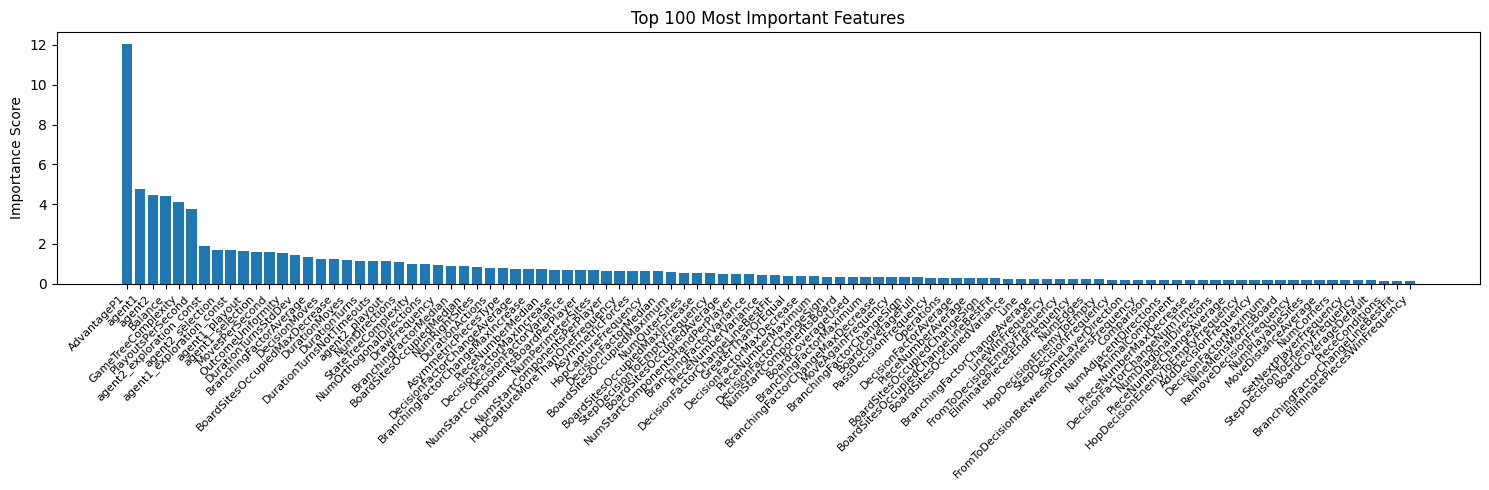

Fold 4 - RMSE: 0.43651943483401334
Fold 5


0:	learn: 0.6043897	test: 0.5852927	best: 0.5852927 (0)	total: 90.2ms	remaining: 4m 30s


50:	learn: 0.3825262	test: 0.4813146	best: 0.4813087 (49)	total: 6.01s	remaining: 5m 47s


100:	learn: 0.3484488	test: 0.4625221	best: 0.4625221 (100)	total: 12.4s	remaining: 5m 57s


150:	learn: 0.3287646	test: 0.4537479	best: 0.4537479 (150)	total: 19s	remaining: 5m 57s


200:	learn: 0.3136221	test: 0.4488872	best: 0.4488872 (200)	total: 25.4s	remaining: 5m 53s


250:	learn: 0.3019878	test: 0.4462728	best: 0.4460333 (244)	total: 31.8s	remaining: 5m 47s


300:	learn: 0.2927756	test: 0.4443661	best: 0.4442566 (299)	total: 38.1s	remaining: 5m 41s


350:	learn: 0.2844088	test: 0.4417517	best: 0.4417517 (350)	total: 44.5s	remaining: 5m 35s


400:	learn: 0.2773415	test: 0.4404783	best: 0.4404440 (397)	total: 50.9s	remaining: 5m 30s


450:	learn: 0.2711741	test: 0.4396368	best: 0.4396252 (449)	total: 57.4s	remaining: 5m 24s


500:	learn: 0.2656944	test: 0.4387502	best: 0.4387338 (496)	total: 1m 3s	remaining: 5m 18s


550:	learn: 0.2606892	test: 0.4383108	best: 0.4382471 (546)	total: 1m 10s	remaining: 5m 13s


600:	learn: 0.2560389	test: 0.4376563	best: 0.4376563 (600)	total: 1m 16s	remaining: 5m 7s


650:	learn: 0.2519064	test: 0.4368888	best: 0.4368859 (646)	total: 1m 23s	remaining: 5m


700:	learn: 0.2473342	test: 0.4363428	best: 0.4363428 (700)	total: 1m 29s	remaining: 4m 54s


750:	learn: 0.2437492	test: 0.4360576	best: 0.4360576 (750)	total: 1m 36s	remaining: 4m 48s


800:	learn: 0.2404274	test: 0.4357575	best: 0.4357285 (799)	total: 1m 42s	remaining: 4m 41s


850:	learn: 0.2372806	test: 0.4355021	best: 0.4354979 (837)	total: 1m 49s	remaining: 4m 35s


900:	learn: 0.2344160	test: 0.4353802	best: 0.4353775 (895)	total: 1m 55s	remaining: 4m 29s


950:	learn: 0.2314656	test: 0.4349620	best: 0.4349620 (950)	total: 2m 2s	remaining: 4m 23s


1000:	learn: 0.2286826	test: 0.4348633	best: 0.4348369 (999)	total: 2m 8s	remaining: 4m 17s


1050:	learn: 0.2259002	test: 0.4347874	best: 0.4347003 (1041)	total: 2m 15s	remaining: 4m 10s


1100:	learn: 0.2235573	test: 0.4345740	best: 0.4345615 (1074)	total: 2m 21s	remaining: 4m 4s


1150:	learn: 0.2213003	test: 0.4344491	best: 0.4344483 (1146)	total: 2m 28s	remaining: 3m 57s


1200:	learn: 0.2191149	test: 0.4344390	best: 0.4343495 (1187)	total: 2m 34s	remaining: 3m 51s


1250:	learn: 0.2167964	test: 0.4343055	best: 0.4342982 (1249)	total: 2m 41s	remaining: 3m 45s


1300:	learn: 0.2148950	test: 0.4341289	best: 0.4340919 (1292)	total: 2m 47s	remaining: 3m 38s


1350:	learn: 0.2131247	test: 0.4339733	best: 0.4339201 (1343)	total: 2m 54s	remaining: 3m 32s


1400:	learn: 0.2109749	test: 0.4338457	best: 0.4338324 (1362)	total: 3m	remaining: 3m 26s


1450:	learn: 0.2091082	test: 0.4336913	best: 0.4336817 (1448)	total: 3m 7s	remaining: 3m 19s


1500:	learn: 0.2071778	test: 0.4336147	best: 0.4335961 (1493)	total: 3m 13s	remaining: 3m 13s


1550:	learn: 0.2053278	test: 0.4336290	best: 0.4335961 (1493)	total: 3m 20s	remaining: 3m 7s


1600:	learn: 0.2035553	test: 0.4335812	best: 0.4335709 (1594)	total: 3m 26s	remaining: 3m


1650:	learn: 0.2021294	test: 0.4334011	best: 0.4334006 (1649)	total: 3m 33s	remaining: 2m 54s


1700:	learn: 0.2003531	test: 0.4333754	best: 0.4333340 (1691)	total: 3m 39s	remaining: 2m 47s


1750:	learn: 0.1986798	test: 0.4332238	best: 0.4332238 (1750)	total: 3m 46s	remaining: 2m 41s


1800:	learn: 0.1970492	test: 0.4331514	best: 0.4331463 (1799)	total: 3m 52s	remaining: 2m 35s


1850:	learn: 0.1954599	test: 0.4331193	best: 0.4331093 (1848)	total: 3m 59s	remaining: 2m 28s


1900:	learn: 0.1936885	test: 0.4330111	best: 0.4329978 (1897)	total: 4m 5s	remaining: 2m 22s


1950:	learn: 0.1919705	test: 0.4329641	best: 0.4329178 (1924)	total: 4m 12s	remaining: 2m 15s


2000:	learn: 0.1900923	test: 0.4328327	best: 0.4328322 (1999)	total: 4m 18s	remaining: 2m 9s


2050:	learn: 0.1885539	test: 0.4328494	best: 0.4328108 (2012)	total: 4m 25s	remaining: 2m 2s


2100:	learn: 0.1871972	test: 0.4327689	best: 0.4327321 (2093)	total: 4m 31s	remaining: 1m 56s


2150:	learn: 0.1857023	test: 0.4328024	best: 0.4327321 (2093)	total: 4m 38s	remaining: 1m 49s


2200:	learn: 0.1842716	test: 0.4327348	best: 0.4327215 (2196)	total: 4m 45s	remaining: 1m 43s


2250:	learn: 0.1827361	test: 0.4326629	best: 0.4326629 (2250)	total: 4m 51s	remaining: 1m 37s


2300:	learn: 0.1813483	test: 0.4325769	best: 0.4325767 (2298)	total: 4m 58s	remaining: 1m 30s


2350:	learn: 0.1800225	test: 0.4325613	best: 0.4325439 (2322)	total: 5m 4s	remaining: 1m 24s


2400:	learn: 0.1785862	test: 0.4324805	best: 0.4324540 (2385)	total: 5m 11s	remaining: 1m 17s


2450:	learn: 0.1772708	test: 0.4324677	best: 0.4324399 (2438)	total: 5m 17s	remaining: 1m 11s


2500:	learn: 0.1759480	test: 0.4323686	best: 0.4323666 (2499)	total: 5m 24s	remaining: 1m 4s


2550:	learn: 0.1747230	test: 0.4323919	best: 0.4323603 (2504)	total: 5m 30s	remaining: 58.2s


2600:	learn: 0.1734524	test: 0.4323711	best: 0.4323578 (2574)	total: 5m 37s	remaining: 51.8s


2650:	learn: 0.1722002	test: 0.4323862	best: 0.4323578 (2574)	total: 5m 43s	remaining: 45.3s


2700:	learn: 0.1708410	test: 0.4322896	best: 0.4322896 (2700)	total: 5m 50s	remaining: 38.8s


2750:	learn: 0.1696832	test: 0.4322465	best: 0.4322386 (2730)	total: 5m 56s	remaining: 32.3s


2800:	learn: 0.1683614	test: 0.4322382	best: 0.4322171 (2776)	total: 6m 3s	remaining: 25.8s


2850:	learn: 0.1671583	test: 0.4322001	best: 0.4321920 (2845)	total: 6m 9s	remaining: 19.3s


2900:	learn: 0.1661109	test: 0.4321711	best: 0.4321711 (2900)	total: 6m 16s	remaining: 12.8s


2950:	learn: 0.1650400	test: 0.4322375	best: 0.4321695 (2904)	total: 6m 22s	remaining: 6.36s


2999:	learn: 0.1640309	test: 0.4322290	best: 0.4321695 (2904)	total: 6m 29s	remaining: 0us

bestTest = 0.4321695009
bestIteration = 2904

Shrink model to first 2905 iterations.


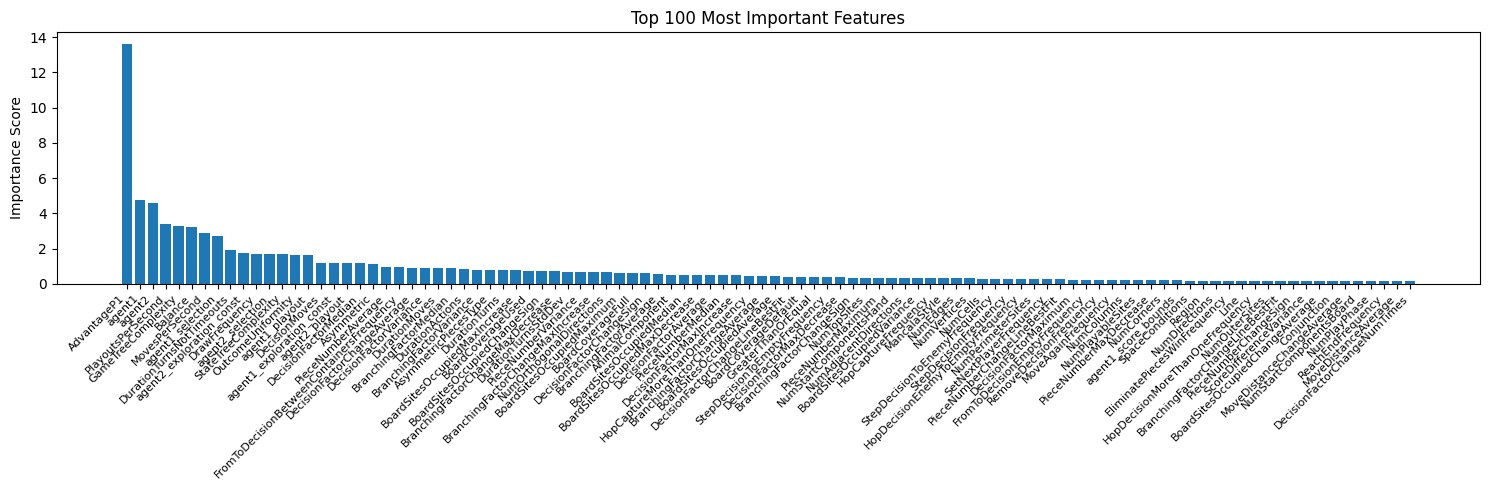

Fold 5 - RMSE: 0.43165982210157794
List of oof scores: [0.4129239733401865, 0.3985645204661043, 0.42604801699126904, 0.43651943483401334, 0.43165982210157794]
Average oof score: 0.4211431535466302


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6094347	test: 0.5701422	best: 0.5701422 (0)	total: 86.4ms	remaining: 4m 19s


50:	learn: 0.3914356	test: 0.4686653	best: 0.4686653 (50)	total: 5.95s	remaining: 5m 43s


100:	learn: 0.3543519	test: 0.4524922	best: 0.4524922 (100)	total: 12.3s	remaining: 5m 52s


150:	learn: 0.3307727	test: 0.4457124	best: 0.4457124 (150)	total: 18.4s	remaining: 5m 47s


200:	learn: 0.3143453	test: 0.4409080	best: 0.4409080 (200)	total: 24.5s	remaining: 5m 41s


250:	learn: 0.3027667	test: 0.4387765	best: 0.4387713 (247)	total: 30.7s	remaining: 5m 36s


300:	learn: 0.2934230	test: 0.4374333	best: 0.4374333 (300)	total: 37s	remaining: 5m 31s


350:	learn: 0.2851722	test: 0.4358589	best: 0.4358589 (350)	total: 43.2s	remaining: 5m 26s


400:	learn: 0.2782734	test: 0.4345789	best: 0.4345789 (400)	total: 49.6s	remaining: 5m 21s


450:	learn: 0.2720422	test: 0.4339813	best: 0.4339791 (448)	total: 55.8s	remaining: 5m 15s


500:	learn: 0.2666481	test: 0.4338314	best: 0.4336294 (481)	total: 1m 2s	remaining: 5m 9s


550:	learn: 0.2611154	test: 0.4333418	best: 0.4332366 (547)	total: 1m 8s	remaining: 5m 3s


600:	learn: 0.2558517	test: 0.4324997	best: 0.4324936 (593)	total: 1m 14s	remaining: 4m 57s


650:	learn: 0.2517111	test: 0.4320606	best: 0.4320606 (650)	total: 1m 20s	remaining: 4m 51s


700:	learn: 0.2473186	test: 0.4317708	best: 0.4317708 (700)	total: 1m 26s	remaining: 4m 45s


750:	learn: 0.2440530	test: 0.4314021	best: 0.4313965 (738)	total: 1m 33s	remaining: 4m 39s


800:	learn: 0.2407384	test: 0.4313605	best: 0.4312571 (768)	total: 1m 39s	remaining: 4m 33s


850:	learn: 0.2376254	test: 0.4313191	best: 0.4312571 (768)	total: 1m 45s	remaining: 4m 27s


900:	learn: 0.2342334	test: 0.4309125	best: 0.4309125 (900)	total: 1m 51s	remaining: 4m 20s


950:	learn: 0.2314643	test: 0.4308463	best: 0.4307970 (942)	total: 1m 58s	remaining: 4m 14s


1000:	learn: 0.2289818	test: 0.4306979	best: 0.4306979 (1000)	total: 2m 4s	remaining: 4m 8s


1050:	learn: 0.2263839	test: 0.4306491	best: 0.4305924 (1030)	total: 2m 10s	remaining: 4m 2s


1100:	learn: 0.2243683	test: 0.4305457	best: 0.4305457 (1100)	total: 2m 16s	remaining: 3m 56s


1150:	learn: 0.2221549	test: 0.4303284	best: 0.4303032 (1144)	total: 2m 23s	remaining: 3m 49s


1200:	learn: 0.2201093	test: 0.4301822	best: 0.4301740 (1198)	total: 2m 29s	remaining: 3m 43s


1250:	learn: 0.2178560	test: 0.4299752	best: 0.4299752 (1250)	total: 2m 36s	remaining: 3m 38s


1300:	learn: 0.2153813	test: 0.4299165	best: 0.4298804 (1296)	total: 2m 42s	remaining: 3m 31s


1350:	learn: 0.2132391	test: 0.4298273	best: 0.4298273 (1350)	total: 2m 48s	remaining: 3m 25s


1400:	learn: 0.2113671	test: 0.4299965	best: 0.4297879 (1358)	total: 2m 54s	remaining: 3m 19s


1450:	learn: 0.2093417	test: 0.4300900	best: 0.4297879 (1358)	total: 3m	remaining: 3m 13s


1500:	learn: 0.2076400	test: 0.4301074	best: 0.4297879 (1358)	total: 3m 7s	remaining: 3m 7s


1550:	learn: 0.2060954	test: 0.4300663	best: 0.4297879 (1358)	total: 3m 13s	remaining: 3m


1600:	learn: 0.2041705	test: 0.4300340	best: 0.4297879 (1358)	total: 3m 19s	remaining: 2m 54s


1650:	learn: 0.2023027	test: 0.4300595	best: 0.4297879 (1358)	total: 3m 26s	remaining: 2m 48s


1700:	learn: 0.2003525	test: 0.4299997	best: 0.4297879 (1358)	total: 3m 32s	remaining: 2m 42s


1750:	learn: 0.1986938	test: 0.4300910	best: 0.4297879 (1358)	total: 3m 38s	remaining: 2m 35s


1800:	learn: 0.1967307	test: 0.4299825	best: 0.4297879 (1358)	total: 3m 44s	remaining: 2m 29s


1850:	learn: 0.1950152	test: 0.4299245	best: 0.4297879 (1358)	total: 3m 51s	remaining: 2m 23s


1900:	learn: 0.1932920	test: 0.4299268	best: 0.4297879 (1358)	total: 3m 57s	remaining: 2m 17s


1950:	learn: 0.1917624	test: 0.4298194	best: 0.4297879 (1358)	total: 4m 3s	remaining: 2m 10s


2000:	learn: 0.1901530	test: 0.4298523	best: 0.4297879 (1358)	total: 4m 9s	remaining: 2m 4s


2050:	learn: 0.1887180	test: 0.4298337	best: 0.4297879 (1358)	total: 4m 15s	remaining: 1m 58s


2100:	learn: 0.1872899	test: 0.4298091	best: 0.4297879 (1358)	total: 4m 22s	remaining: 1m 52s


2150:	learn: 0.1858657	test: 0.4297768	best: 0.4297743 (2147)	total: 4m 28s	remaining: 1m 46s


2200:	learn: 0.1844558	test: 0.4296427	best: 0.4296230 (2193)	total: 4m 34s	remaining: 1m 39s


2250:	learn: 0.1828365	test: 0.4295406	best: 0.4295406 (2250)	total: 4m 41s	remaining: 1m 33s


2300:	learn: 0.1815729	test: 0.4294654	best: 0.4294529 (2293)	total: 4m 47s	remaining: 1m 27s


2350:	learn: 0.1804451	test: 0.4295065	best: 0.4294529 (2293)	total: 4m 53s	remaining: 1m 21s


2400:	learn: 0.1789896	test: 0.4295185	best: 0.4294529 (2293)	total: 4m 59s	remaining: 1m 14s


2450:	learn: 0.1779081	test: 0.4295873	best: 0.4294529 (2293)	total: 5m 6s	remaining: 1m 8s


2500:	learn: 0.1766259	test: 0.4295890	best: 0.4294529 (2293)	total: 5m 12s	remaining: 1m 2s


2550:	learn: 0.1753617	test: 0.4295298	best: 0.4294529 (2293)	total: 5m 18s	remaining: 56.1s


2600:	learn: 0.1740310	test: 0.4295034	best: 0.4294529 (2293)	total: 5m 24s	remaining: 49.8s


2650:	learn: 0.1728568	test: 0.4295171	best: 0.4294529 (2293)	total: 5m 31s	remaining: 43.6s


2700:	learn: 0.1714456	test: 0.4294820	best: 0.4294529 (2293)	total: 5m 37s	remaining: 37.3s


2750:	learn: 0.1704790	test: 0.4294846	best: 0.4294529 (2293)	total: 5m 43s	remaining: 31.1s


2800:	learn: 0.1693465	test: 0.4295071	best: 0.4294529 (2293)	total: 5m 49s	remaining: 24.9s


2850:	learn: 0.1683996	test: 0.4294732	best: 0.4294504 (2837)	total: 5m 56s	remaining: 18.6s


2900:	learn: 0.1673462	test: 0.4295228	best: 0.4294504 (2837)	total: 6m 2s	remaining: 12.4s


2950:	learn: 0.1662845	test: 0.4295132	best: 0.4294504 (2837)	total: 6m 8s	remaining: 6.13s


2999:	learn: 0.1651946	test: 0.4295301	best: 0.4294504 (2837)	total: 6m 15s	remaining: 0us

bestTest = 0.4294504097
bestIteration = 2837

Shrink model to first 2838 iterations.


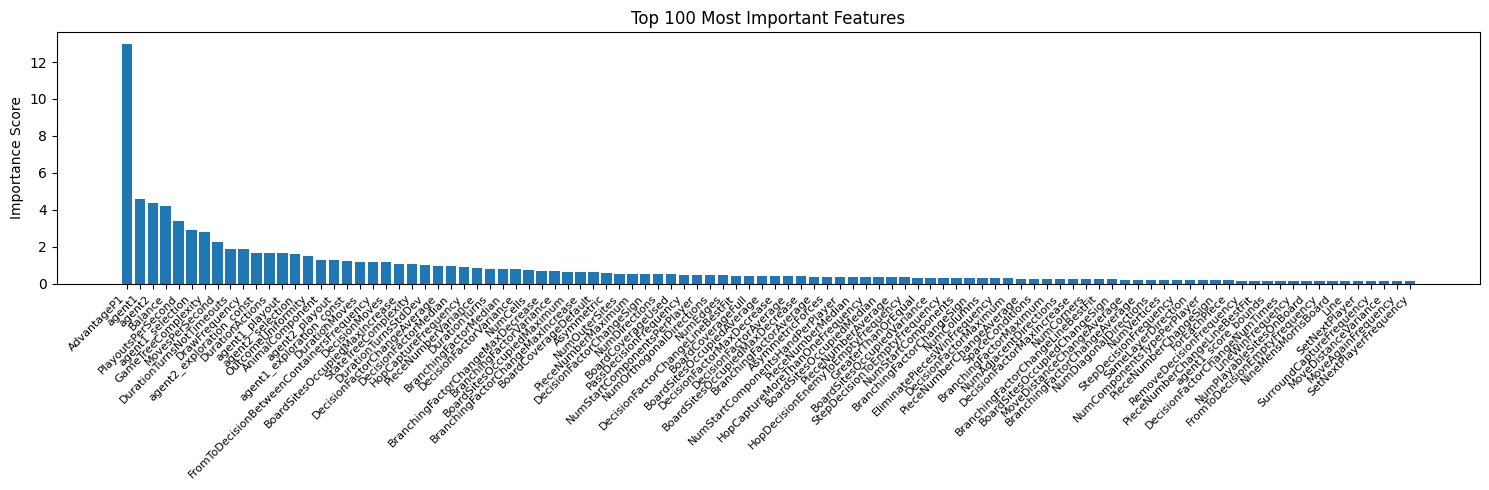

Fold 1 - RMSE: 0.42898276234297555
Fold 2


0:	learn: 0.6070120	test: 0.5696836	best: 0.5696836 (0)	total: 96ms	remaining: 4m 47s


50:	learn: 0.3878643	test: 0.4660899	best: 0.4660899 (50)	total: 6.03s	remaining: 5m 48s


100:	learn: 0.3518361	test: 0.4459635	best: 0.4459635 (100)	total: 12.4s	remaining: 5m 54s


150:	learn: 0.3301528	test: 0.4360918	best: 0.4360918 (150)	total: 18.6s	remaining: 5m 50s


200:	learn: 0.3138081	test: 0.4315164	best: 0.4313947 (197)	total: 24.8s	remaining: 5m 45s


250:	learn: 0.3023274	test: 0.4289804	best: 0.4289804 (250)	total: 31s	remaining: 5m 39s


300:	learn: 0.2921411	test: 0.4264601	best: 0.4264601 (300)	total: 37.3s	remaining: 5m 34s


350:	learn: 0.2848205	test: 0.4246396	best: 0.4246396 (350)	total: 43.6s	remaining: 5m 29s


400:	learn: 0.2768809	test: 0.4236361	best: 0.4235838 (394)	total: 49.9s	remaining: 5m 23s


450:	learn: 0.2705066	test: 0.4220426	best: 0.4220426 (450)	total: 56.1s	remaining: 5m 17s


500:	learn: 0.2649526	test: 0.4210421	best: 0.4209983 (499)	total: 1m 2s	remaining: 5m 11s


550:	learn: 0.2594714	test: 0.4201572	best: 0.4201572 (550)	total: 1m 8s	remaining: 5m 5s


600:	learn: 0.2551875	test: 0.4193001	best: 0.4193001 (599)	total: 1m 14s	remaining: 4m 59s


650:	learn: 0.2509318	test: 0.4185369	best: 0.4185324 (649)	total: 1m 21s	remaining: 4m 53s


700:	learn: 0.2468588	test: 0.4177178	best: 0.4177178 (700)	total: 1m 27s	remaining: 4m 47s


750:	learn: 0.2434591	test: 0.4171421	best: 0.4170872 (744)	total: 1m 34s	remaining: 4m 41s


800:	learn: 0.2405298	test: 0.4168387	best: 0.4168373 (799)	total: 1m 40s	remaining: 4m 35s


850:	learn: 0.2372861	test: 0.4161994	best: 0.4161994 (850)	total: 1m 46s	remaining: 4m 29s


900:	learn: 0.2345410	test: 0.4158552	best: 0.4158552 (900)	total: 1m 52s	remaining: 4m 23s


950:	learn: 0.2315660	test: 0.4155556	best: 0.4155397 (949)	total: 1m 59s	remaining: 4m 16s


1000:	learn: 0.2286872	test: 0.4155603	best: 0.4155265 (961)	total: 2m 5s	remaining: 4m 10s


1050:	learn: 0.2258778	test: 0.4153447	best: 0.4153447 (1050)	total: 2m 11s	remaining: 4m 4s


1100:	learn: 0.2238487	test: 0.4151152	best: 0.4151149 (1099)	total: 2m 18s	remaining: 3m 58s


1150:	learn: 0.2217380	test: 0.4149298	best: 0.4149225 (1148)	total: 2m 24s	remaining: 3m 52s


1200:	learn: 0.2192184	test: 0.4147023	best: 0.4147023 (1200)	total: 2m 31s	remaining: 3m 46s


1250:	learn: 0.2170420	test: 0.4146543	best: 0.4146317 (1223)	total: 2m 37s	remaining: 3m 40s


1300:	learn: 0.2147310	test: 0.4144758	best: 0.4144736 (1299)	total: 2m 43s	remaining: 3m 33s


1350:	learn: 0.2120904	test: 0.4144875	best: 0.4143910 (1325)	total: 2m 49s	remaining: 3m 27s


1400:	learn: 0.2098074	test: 0.4142298	best: 0.4142298 (1400)	total: 2m 56s	remaining: 3m 21s


1450:	learn: 0.2079271	test: 0.4140226	best: 0.4140226 (1450)	total: 3m 2s	remaining: 3m 14s


1500:	learn: 0.2062287	test: 0.4139955	best: 0.4139532 (1491)	total: 3m 9s	remaining: 3m 8s


1550:	learn: 0.2044915	test: 0.4139040	best: 0.4138847 (1523)	total: 3m 15s	remaining: 3m 2s


1600:	learn: 0.2028967	test: 0.4138013	best: 0.4137966 (1599)	total: 3m 21s	remaining: 2m 56s


1650:	learn: 0.2010633	test: 0.4137738	best: 0.4137528 (1646)	total: 3m 28s	remaining: 2m 50s


1700:	learn: 0.1992909	test: 0.4137474	best: 0.4137474 (1700)	total: 3m 34s	remaining: 2m 43s


1750:	learn: 0.1977326	test: 0.4136901	best: 0.4136901 (1750)	total: 3m 41s	remaining: 2m 37s


1800:	learn: 0.1957950	test: 0.4137513	best: 0.4136894 (1751)	total: 3m 47s	remaining: 2m 31s


1850:	learn: 0.1940971	test: 0.4137567	best: 0.4136894 (1751)	total: 3m 53s	remaining: 2m 24s


1900:	learn: 0.1926613	test: 0.4136206	best: 0.4136206 (1900)	total: 3m 59s	remaining: 2m 18s


1950:	learn: 0.1913023	test: 0.4136075	best: 0.4135811 (1934)	total: 4m 6s	remaining: 2m 12s


2000:	learn: 0.1897576	test: 0.4136818	best: 0.4135811 (1934)	total: 4m 12s	remaining: 2m 6s


2050:	learn: 0.1880070	test: 0.4136058	best: 0.4135811 (1934)	total: 4m 18s	remaining: 1m 59s


2100:	learn: 0.1866859	test: 0.4136147	best: 0.4135251 (2065)	total: 4m 25s	remaining: 1m 53s


2150:	learn: 0.1852735	test: 0.4135261	best: 0.4134922 (2131)	total: 4m 31s	remaining: 1m 47s


2200:	learn: 0.1839094	test: 0.4135529	best: 0.4134922 (2131)	total: 4m 37s	remaining: 1m 40s


2250:	learn: 0.1825277	test: 0.4135320	best: 0.4134922 (2131)	total: 4m 44s	remaining: 1m 34s


2300:	learn: 0.1810955	test: 0.4133463	best: 0.4133442 (2296)	total: 4m 50s	remaining: 1m 28s


2350:	learn: 0.1796936	test: 0.4133090	best: 0.4133042 (2347)	total: 4m 56s	remaining: 1m 21s


2400:	learn: 0.1784919	test: 0.4132755	best: 0.4132675 (2391)	total: 5m 3s	remaining: 1m 15s


2450:	learn: 0.1770694	test: 0.4132716	best: 0.4132485 (2401)	total: 5m 9s	remaining: 1m 9s


2500:	learn: 0.1756193	test: 0.4132403	best: 0.4132398 (2498)	total: 5m 15s	remaining: 1m 3s


2550:	learn: 0.1743288	test: 0.4132530	best: 0.4132209 (2507)	total: 5m 22s	remaining: 56.7s


2600:	learn: 0.1730494	test: 0.4132278	best: 0.4132209 (2507)	total: 5m 28s	remaining: 50.4s


2650:	learn: 0.1718753	test: 0.4131206	best: 0.4131206 (2650)	total: 5m 34s	remaining: 44.1s


2700:	learn: 0.1706469	test: 0.4131377	best: 0.4130804 (2661)	total: 5m 41s	remaining: 37.8s


2750:	learn: 0.1694492	test: 0.4130667	best: 0.4130596 (2744)	total: 5m 47s	remaining: 31.4s


2800:	learn: 0.1682881	test: 0.4131436	best: 0.4130596 (2744)	total: 5m 53s	remaining: 25.1s


2850:	learn: 0.1671422	test: 0.4131621	best: 0.4130596 (2744)	total: 5m 59s	remaining: 18.8s


2900:	learn: 0.1660408	test: 0.4130967	best: 0.4130596 (2744)	total: 6m 6s	remaining: 12.5s


2950:	learn: 0.1649260	test: 0.4130827	best: 0.4130596 (2744)	total: 6m 12s	remaining: 6.19s


2999:	learn: 0.1637994	test: 0.4131182	best: 0.4130596 (2744)	total: 6m 18s	remaining: 0us

bestTest = 0.4130595817
bestIteration = 2744

Shrink model to first 2745 iterations.


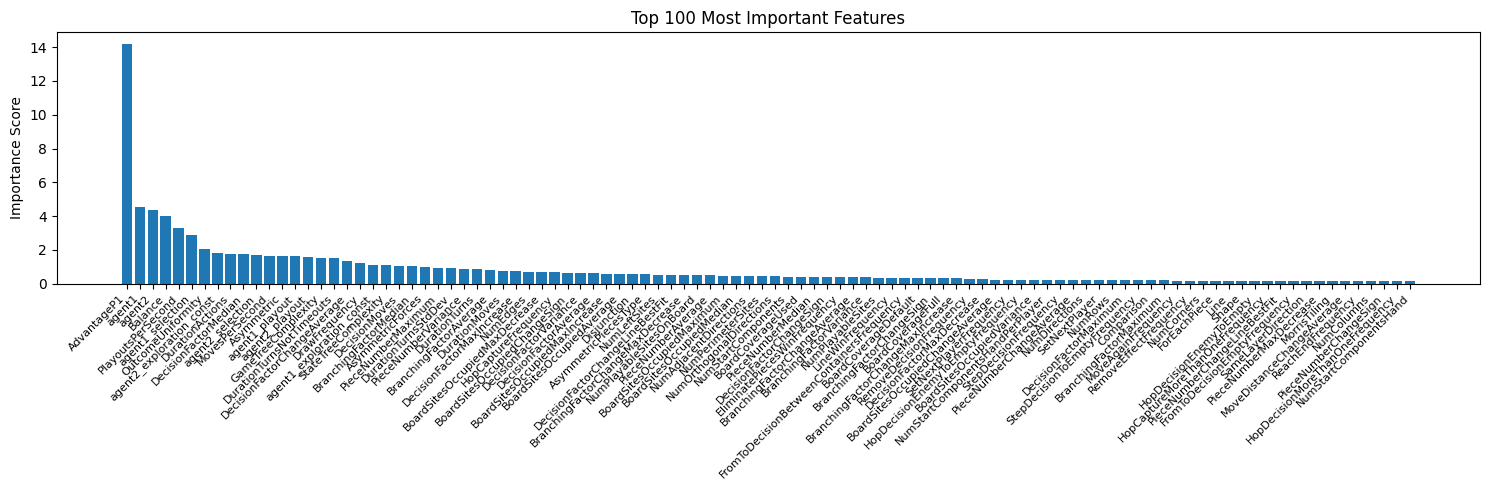

Fold 2 - RMSE: 0.4126912237584462
Fold 3


0:	learn: 0.6118191	test: 0.5707950	best: 0.5707950 (0)	total: 98.6ms	remaining: 4m 55s


50:	learn: 0.3905211	test: 0.4595904	best: 0.4595904 (50)	total: 5.85s	remaining: 5m 38s


100:	learn: 0.3508945	test: 0.4428173	best: 0.4428173 (100)	total: 11.9s	remaining: 5m 41s


150:	learn: 0.3286393	test: 0.4353405	best: 0.4353405 (150)	total: 17.9s	remaining: 5m 38s


200:	learn: 0.3138520	test: 0.4312142	best: 0.4312142 (200)	total: 24.1s	remaining: 5m 35s


250:	learn: 0.3019317	test: 0.4288229	best: 0.4287769 (249)	total: 30.4s	remaining: 5m 32s


300:	learn: 0.2928806	test: 0.4265979	best: 0.4265979 (300)	total: 36.7s	remaining: 5m 28s


350:	learn: 0.2848152	test: 0.4258091	best: 0.4258091 (350)	total: 42.9s	remaining: 5m 23s


400:	learn: 0.2766621	test: 0.4245824	best: 0.4245824 (400)	total: 48.9s	remaining: 5m 17s


450:	learn: 0.2699371	test: 0.4237686	best: 0.4237686 (450)	total: 55.1s	remaining: 5m 11s


500:	learn: 0.2647062	test: 0.4232345	best: 0.4232345 (500)	total: 1m 1s	remaining: 5m 5s


550:	learn: 0.2592602	test: 0.4227157	best: 0.4226810 (545)	total: 1m 7s	remaining: 4m 59s


600:	learn: 0.2548527	test: 0.4223016	best: 0.4222925 (598)	total: 1m 13s	remaining: 4m 54s


650:	learn: 0.2504225	test: 0.4218666	best: 0.4218666 (650)	total: 1m 19s	remaining: 4m 48s


700:	learn: 0.2461280	test: 0.4214277	best: 0.4214277 (700)	total: 1m 25s	remaining: 4m 41s


750:	learn: 0.2421302	test: 0.4208576	best: 0.4208129 (746)	total: 1m 31s	remaining: 4m 35s


800:	learn: 0.2385443	test: 0.4206376	best: 0.4206376 (800)	total: 1m 38s	remaining: 4m 29s


850:	learn: 0.2352011	test: 0.4205122	best: 0.4204615 (830)	total: 1m 44s	remaining: 4m 23s


900:	learn: 0.2319412	test: 0.4203991	best: 0.4203811 (898)	total: 1m 50s	remaining: 4m 17s


950:	learn: 0.2289873	test: 0.4200449	best: 0.4200319 (948)	total: 1m 56s	remaining: 4m 10s


1000:	learn: 0.2260568	test: 0.4197478	best: 0.4197478 (1000)	total: 2m 2s	remaining: 4m 4s


1050:	learn: 0.2234305	test: 0.4194399	best: 0.4193882 (1042)	total: 2m 8s	remaining: 3m 58s


1100:	learn: 0.2207198	test: 0.4193344	best: 0.4193344 (1100)	total: 2m 14s	remaining: 3m 52s


1150:	learn: 0.2183259	test: 0.4191873	best: 0.4191860 (1146)	total: 2m 21s	remaining: 3m 46s


1200:	learn: 0.2160442	test: 0.4189912	best: 0.4189396 (1196)	total: 2m 27s	remaining: 3m 40s


1250:	learn: 0.2135250	test: 0.4186799	best: 0.4186750 (1248)	total: 2m 33s	remaining: 3m 35s


1300:	learn: 0.2114522	test: 0.4184987	best: 0.4184695 (1284)	total: 2m 40s	remaining: 3m 28s


1350:	learn: 0.2091971	test: 0.4182151	best: 0.4182138 (1349)	total: 2m 46s	remaining: 3m 22s


1400:	learn: 0.2069043	test: 0.4179656	best: 0.4179649 (1398)	total: 2m 52s	remaining: 3m 16s


1450:	learn: 0.2047366	test: 0.4179199	best: 0.4178558 (1428)	total: 2m 58s	remaining: 3m 10s


1500:	learn: 0.2022783	test: 0.4177358	best: 0.4177240 (1491)	total: 3m 4s	remaining: 3m 4s


1550:	learn: 0.2004149	test: 0.4176966	best: 0.4176623 (1528)	total: 3m 10s	remaining: 2m 58s


1600:	learn: 0.1985366	test: 0.4176928	best: 0.4176623 (1528)	total: 3m 17s	remaining: 2m 52s


1650:	learn: 0.1967671	test: 0.4176102	best: 0.4176005 (1620)	total: 3m 23s	remaining: 2m 46s


1700:	learn: 0.1948436	test: 0.4174931	best: 0.4174571 (1692)	total: 3m 29s	remaining: 2m 39s


1750:	learn: 0.1929414	test: 0.4174227	best: 0.4174106 (1749)	total: 3m 35s	remaining: 2m 33s


1800:	learn: 0.1910920	test: 0.4172399	best: 0.4172210 (1796)	total: 3m 41s	remaining: 2m 27s


1850:	learn: 0.1893762	test: 0.4171329	best: 0.4171250 (1837)	total: 3m 47s	remaining: 2m 21s


1900:	learn: 0.1872619	test: 0.4170573	best: 0.4170544 (1898)	total: 3m 53s	remaining: 2m 15s


1950:	learn: 0.1856401	test: 0.4170523	best: 0.4170358 (1931)	total: 3m 59s	remaining: 2m 8s


2000:	learn: 0.1837626	test: 0.4169071	best: 0.4168992 (1996)	total: 4m 5s	remaining: 2m 2s


2050:	learn: 0.1821754	test: 0.4168561	best: 0.4168239 (2036)	total: 4m 12s	remaining: 1m 56s


2100:	learn: 0.1803527	test: 0.4166864	best: 0.4166864 (2100)	total: 4m 18s	remaining: 1m 50s


2150:	learn: 0.1790518	test: 0.4167169	best: 0.4166726 (2113)	total: 4m 24s	remaining: 1m 44s


2200:	learn: 0.1774616	test: 0.4166289	best: 0.4166194 (2197)	total: 4m 30s	remaining: 1m 38s


2250:	learn: 0.1758890	test: 0.4166445	best: 0.4166074 (2218)	total: 4m 36s	remaining: 1m 32s


2300:	learn: 0.1743643	test: 0.4166867	best: 0.4166074 (2218)	total: 4m 42s	remaining: 1m 25s


2350:	learn: 0.1730115	test: 0.4166355	best: 0.4166074 (2218)	total: 4m 48s	remaining: 1m 19s


2400:	learn: 0.1713558	test: 0.4164298	best: 0.4164196 (2396)	total: 4m 54s	remaining: 1m 13s


2450:	learn: 0.1699418	test: 0.4164275	best: 0.4164157 (2446)	total: 5m 1s	remaining: 1m 7s


2500:	learn: 0.1682717	test: 0.4163798	best: 0.4163677 (2498)	total: 5m 7s	remaining: 1m 1s


2550:	learn: 0.1669507	test: 0.4163950	best: 0.4163677 (2498)	total: 5m 13s	remaining: 55.2s


2600:	learn: 0.1656110	test: 0.4163890	best: 0.4163677 (2498)	total: 5m 19s	remaining: 49s


2650:	learn: 0.1644406	test: 0.4163735	best: 0.4163671 (2644)	total: 5m 25s	remaining: 42.9s


2700:	learn: 0.1632050	test: 0.4163959	best: 0.4163450 (2670)	total: 5m 31s	remaining: 36.7s


2750:	learn: 0.1620606	test: 0.4163531	best: 0.4163450 (2670)	total: 5m 38s	remaining: 30.6s


2800:	learn: 0.1608400	test: 0.4163585	best: 0.4163321 (2783)	total: 5m 44s	remaining: 24.5s


2850:	learn: 0.1595570	test: 0.4163474	best: 0.4163130 (2831)	total: 5m 50s	remaining: 18.3s


2900:	learn: 0.1585757	test: 0.4163329	best: 0.4163014 (2877)	total: 5m 56s	remaining: 12.2s


2950:	learn: 0.1574086	test: 0.4163165	best: 0.4162956 (2931)	total: 6m 2s	remaining: 6.03s


2999:	learn: 0.1563067	test: 0.4163263	best: 0.4162956 (2931)	total: 6m 8s	remaining: 0us

bestTest = 0.4162955577
bestIteration = 2931

Shrink model to first 2932 iterations.


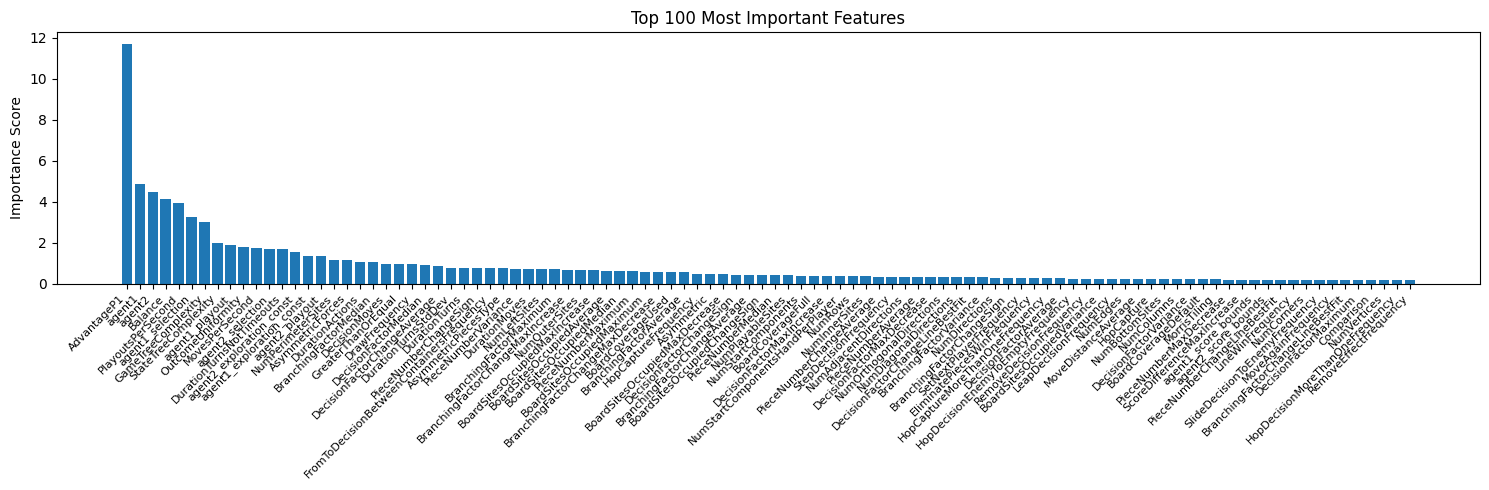

Fold 3 - RMSE: 0.4159486144129323
Fold 4


0:	learn: 0.6097928	test: 0.5651798	best: 0.5651798 (0)	total: 104ms	remaining: 5m 12s


50:	learn: 0.3875636	test: 0.4607820	best: 0.4607820 (50)	total: 5.87s	remaining: 5m 39s


100:	learn: 0.3493497	test: 0.4472360	best: 0.4472358 (99)	total: 11.9s	remaining: 5m 40s


150:	learn: 0.3268348	test: 0.4417420	best: 0.4417420 (150)	total: 17.9s	remaining: 5m 37s


200:	learn: 0.3113785	test: 0.4368739	best: 0.4368739 (200)	total: 24s	remaining: 5m 33s


250:	learn: 0.2999113	test: 0.4348227	best: 0.4347990 (249)	total: 30.1s	remaining: 5m 29s


300:	learn: 0.2901195	test: 0.4330764	best: 0.4330682 (299)	total: 36.2s	remaining: 5m 24s


350:	learn: 0.2817771	test: 0.4315882	best: 0.4315882 (350)	total: 42.2s	remaining: 5m 18s


400:	learn: 0.2744616	test: 0.4301580	best: 0.4301580 (400)	total: 48.2s	remaining: 5m 12s


450:	learn: 0.2682096	test: 0.4292937	best: 0.4292937 (450)	total: 54.2s	remaining: 5m 6s


500:	learn: 0.2628197	test: 0.4283629	best: 0.4283629 (500)	total: 1m	remaining: 5m


550:	learn: 0.2579369	test: 0.4277788	best: 0.4277755 (549)	total: 1m 6s	remaining: 4m 55s


600:	learn: 0.2535834	test: 0.4272105	best: 0.4271907 (599)	total: 1m 12s	remaining: 4m 49s


650:	learn: 0.2493635	test: 0.4267351	best: 0.4267268 (648)	total: 1m 18s	remaining: 4m 43s


700:	learn: 0.2458860	test: 0.4264746	best: 0.4264626 (699)	total: 1m 24s	remaining: 4m 37s


750:	learn: 0.2421618	test: 0.4260062	best: 0.4259871 (731)	total: 1m 30s	remaining: 4m 32s


800:	learn: 0.2389812	test: 0.4257349	best: 0.4257349 (800)	total: 1m 36s	remaining: 4m 26s


850:	learn: 0.2359801	test: 0.4254938	best: 0.4254340 (846)	total: 1m 43s	remaining: 4m 20s


900:	learn: 0.2334850	test: 0.4253979	best: 0.4253324 (897)	total: 1m 49s	remaining: 4m 14s


950:	learn: 0.2304169	test: 0.4251113	best: 0.4251113 (950)	total: 1m 55s	remaining: 4m 8s


1000:	learn: 0.2275858	test: 0.4248123	best: 0.4247899 (992)	total: 2m 1s	remaining: 4m 2s


1050:	learn: 0.2251380	test: 0.4244661	best: 0.4244542 (1045)	total: 2m 7s	remaining: 3m 56s


1100:	learn: 0.2226201	test: 0.4242658	best: 0.4242523 (1094)	total: 2m 13s	remaining: 3m 50s


1150:	learn: 0.2202559	test: 0.4242110	best: 0.4241409 (1121)	total: 2m 20s	remaining: 3m 44s


1200:	learn: 0.2180185	test: 0.4241108	best: 0.4240819 (1182)	total: 2m 26s	remaining: 3m 38s


1250:	learn: 0.2157046	test: 0.4240700	best: 0.4240700 (1250)	total: 2m 32s	remaining: 3m 32s


1300:	learn: 0.2136535	test: 0.4239418	best: 0.4239336 (1295)	total: 2m 38s	remaining: 3m 26s


1350:	learn: 0.2115183	test: 0.4237037	best: 0.4237037 (1350)	total: 2m 44s	remaining: 3m 20s


1400:	learn: 0.2092874	test: 0.4234673	best: 0.4234673 (1400)	total: 2m 50s	remaining: 3m 14s


1450:	learn: 0.2074797	test: 0.4233537	best: 0.4233511 (1449)	total: 2m 56s	remaining: 3m 8s


1500:	learn: 0.2055763	test: 0.4231985	best: 0.4231926 (1497)	total: 3m 2s	remaining: 3m 2s


1550:	learn: 0.2038434	test: 0.4231054	best: 0.4230788 (1534)	total: 3m 8s	remaining: 2m 56s


1600:	learn: 0.2019092	test: 0.4230154	best: 0.4229956 (1592)	total: 3m 14s	remaining: 2m 50s


1650:	learn: 0.2000691	test: 0.4230307	best: 0.4229722 (1606)	total: 3m 20s	remaining: 2m 44s


1700:	learn: 0.1981698	test: 0.4230206	best: 0.4229722 (1606)	total: 3m 26s	remaining: 2m 38s


1750:	learn: 0.1964618	test: 0.4229880	best: 0.4229278 (1733)	total: 3m 33s	remaining: 2m 32s


1800:	learn: 0.1949250	test: 0.4229226	best: 0.4228740 (1783)	total: 3m 39s	remaining: 2m 25s


1850:	learn: 0.1931801	test: 0.4229456	best: 0.4228740 (1783)	total: 3m 45s	remaining: 2m 19s


1900:	learn: 0.1916596	test: 0.4228450	best: 0.4228246 (1887)	total: 3m 51s	remaining: 2m 13s


1950:	learn: 0.1901736	test: 0.4228457	best: 0.4228160 (1932)	total: 3m 57s	remaining: 2m 7s


2000:	learn: 0.1887988	test: 0.4228925	best: 0.4228160 (1932)	total: 4m 3s	remaining: 2m 1s


2050:	learn: 0.1872797	test: 0.4228117	best: 0.4228117 (2050)	total: 4m 9s	remaining: 1m 55s


2100:	learn: 0.1858015	test: 0.4227312	best: 0.4227312 (2100)	total: 4m 16s	remaining: 1m 49s


2150:	learn: 0.1843689	test: 0.4226178	best: 0.4226078 (2148)	total: 4m 22s	remaining: 1m 43s


2200:	learn: 0.1830272	test: 0.4225780	best: 0.4225780 (2200)	total: 4m 28s	remaining: 1m 37s


2250:	learn: 0.1816683	test: 0.4225426	best: 0.4225235 (2213)	total: 4m 34s	remaining: 1m 31s


2300:	learn: 0.1803467	test: 0.4225365	best: 0.4225105 (2271)	total: 4m 40s	remaining: 1m 25s


2350:	learn: 0.1790851	test: 0.4224890	best: 0.4224551 (2335)	total: 4m 46s	remaining: 1m 19s


2400:	learn: 0.1776266	test: 0.4224937	best: 0.4224551 (2335)	total: 4m 52s	remaining: 1m 13s


2450:	learn: 0.1763598	test: 0.4224863	best: 0.4224551 (2335)	total: 4m 59s	remaining: 1m 7s


2500:	learn: 0.1750631	test: 0.4224341	best: 0.4224121 (2487)	total: 5m 5s	remaining: 1m


2550:	learn: 0.1738639	test: 0.4224224	best: 0.4224071 (2541)	total: 5m 11s	remaining: 54.8s


2600:	learn: 0.1724228	test: 0.4223854	best: 0.4223711 (2577)	total: 5m 17s	remaining: 48.7s


2650:	learn: 0.1712725	test: 0.4223604	best: 0.4223473 (2641)	total: 5m 23s	remaining: 42.6s


2700:	learn: 0.1702540	test: 0.4223378	best: 0.4223360 (2694)	total: 5m 30s	remaining: 36.6s


2750:	learn: 0.1692405	test: 0.4223597	best: 0.4223352 (2713)	total: 5m 36s	remaining: 30.4s


2800:	learn: 0.1681237	test: 0.4224319	best: 0.4223352 (2713)	total: 5m 42s	remaining: 24.3s


2850:	learn: 0.1670037	test: 0.4224034	best: 0.4223352 (2713)	total: 5m 48s	remaining: 18.2s


2900:	learn: 0.1660545	test: 0.4223936	best: 0.4223352 (2713)	total: 5m 55s	remaining: 12.1s


2950:	learn: 0.1646801	test: 0.4223776	best: 0.4223352 (2713)	total: 6m 1s	remaining: 6s


2999:	learn: 0.1634637	test: 0.4224297	best: 0.4223352 (2713)	total: 6m 7s	remaining: 0us

bestTest = 0.4223352246
bestIteration = 2713

Shrink model to first 2714 iterations.


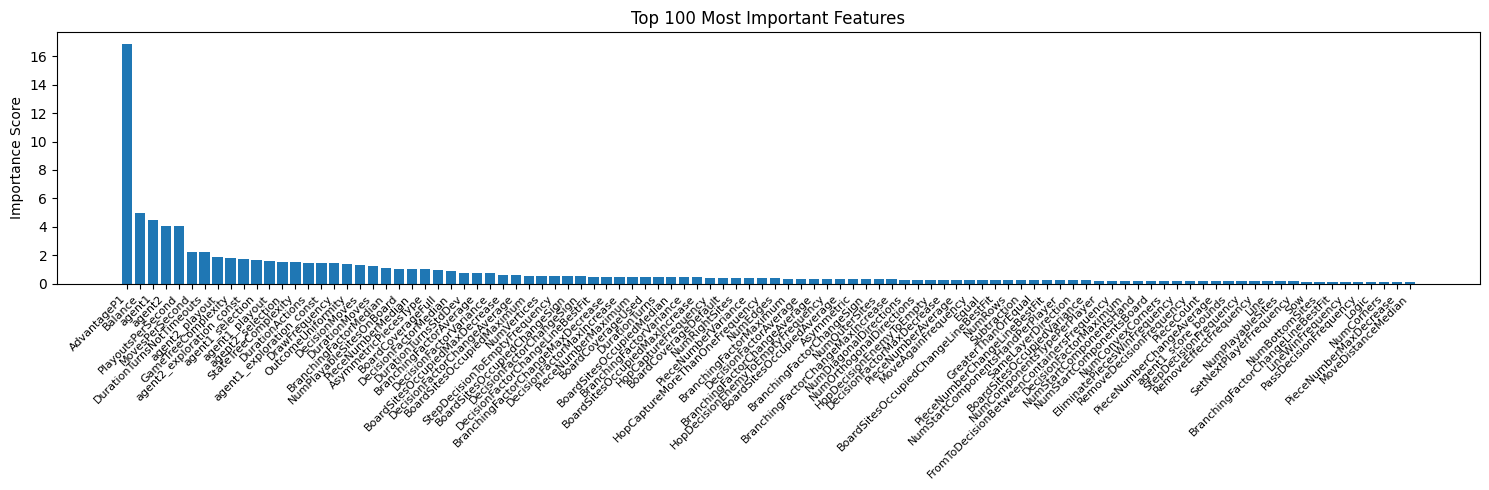

Fold 4 - RMSE: 0.421581212875255
Fold 5


0:	learn: 0.6061827	test: 0.5788250	best: 0.5788250 (0)	total: 88.7ms	remaining: 4m 26s


50:	learn: 0.3878777	test: 0.4787967	best: 0.4787967 (50)	total: 5.95s	remaining: 5m 43s


100:	learn: 0.3506369	test: 0.4573061	best: 0.4573061 (100)	total: 12.2s	remaining: 5m 51s


150:	learn: 0.3297554	test: 0.4486739	best: 0.4486739 (150)	total: 18.4s	remaining: 5m 47s


200:	learn: 0.3134244	test: 0.4428922	best: 0.4427771 (199)	total: 24.5s	remaining: 5m 41s


250:	learn: 0.3016176	test: 0.4397415	best: 0.4397379 (248)	total: 30.6s	remaining: 5m 35s


300:	learn: 0.2918640	test: 0.4377281	best: 0.4377016 (299)	total: 36.7s	remaining: 5m 29s


350:	learn: 0.2836671	test: 0.4359403	best: 0.4359332 (348)	total: 43s	remaining: 5m 24s


400:	learn: 0.2758700	test: 0.4345215	best: 0.4345215 (400)	total: 49s	remaining: 5m 17s


450:	learn: 0.2691639	test: 0.4334720	best: 0.4333873 (445)	total: 55.1s	remaining: 5m 11s


500:	learn: 0.2636746	test: 0.4328622	best: 0.4328622 (500)	total: 1m 1s	remaining: 5m 6s


550:	learn: 0.2586053	test: 0.4321740	best: 0.4321705 (546)	total: 1m 8s	remaining: 5m 2s


600:	learn: 0.2544233	test: 0.4314071	best: 0.4314031 (599)	total: 1m 14s	remaining: 4m 56s


650:	learn: 0.2506381	test: 0.4311912	best: 0.4311645 (649)	total: 1m 20s	remaining: 4m 50s


700:	learn: 0.2470593	test: 0.4307198	best: 0.4307198 (700)	total: 1m 26s	remaining: 4m 44s


750:	learn: 0.2430952	test: 0.4305744	best: 0.4304531 (729)	total: 1m 33s	remaining: 4m 38s


800:	learn: 0.2394441	test: 0.4301788	best: 0.4301726 (797)	total: 1m 39s	remaining: 4m 32s


850:	learn: 0.2357411	test: 0.4299395	best: 0.4299145 (844)	total: 1m 45s	remaining: 4m 26s


900:	learn: 0.2327813	test: 0.4297931	best: 0.4297607 (898)	total: 1m 51s	remaining: 4m 20s


950:	learn: 0.2300386	test: 0.4297548	best: 0.4297306 (936)	total: 1m 57s	remaining: 4m 14s


1000:	learn: 0.2271558	test: 0.4296636	best: 0.4296382 (996)	total: 2m 4s	remaining: 4m 7s


1050:	learn: 0.2246682	test: 0.4293174	best: 0.4293139 (1049)	total: 2m 10s	remaining: 4m 1s


1100:	learn: 0.2224919	test: 0.4290707	best: 0.4290707 (1100)	total: 2m 16s	remaining: 3m 55s


1150:	learn: 0.2200621	test: 0.4289641	best: 0.4289358 (1111)	total: 2m 23s	remaining: 3m 49s


1200:	learn: 0.2174700	test: 0.4288634	best: 0.4288630 (1193)	total: 2m 29s	remaining: 3m 43s


1250:	learn: 0.2150017	test: 0.4287343	best: 0.4287343 (1250)	total: 2m 35s	remaining: 3m 37s


1300:	learn: 0.2127791	test: 0.4286806	best: 0.4286678 (1294)	total: 2m 41s	remaining: 3m 31s


1350:	learn: 0.2107557	test: 0.4287173	best: 0.4286421 (1322)	total: 2m 48s	remaining: 3m 25s


1400:	learn: 0.2086777	test: 0.4286651	best: 0.4285833 (1374)	total: 2m 54s	remaining: 3m 18s


1450:	learn: 0.2067085	test: 0.4285990	best: 0.4285327 (1429)	total: 3m	remaining: 3m 12s


1500:	learn: 0.2049810	test: 0.4284221	best: 0.4284221 (1500)	total: 3m 6s	remaining: 3m 6s


1550:	learn: 0.2032996	test: 0.4283683	best: 0.4283459 (1542)	total: 3m 13s	remaining: 3m


1600:	learn: 0.2015633	test: 0.4284803	best: 0.4283459 (1542)	total: 3m 19s	remaining: 2m 54s


1650:	learn: 0.1997290	test: 0.4284910	best: 0.4283459 (1542)	total: 3m 25s	remaining: 2m 47s


1700:	learn: 0.1978241	test: 0.4283523	best: 0.4283459 (1542)	total: 3m 31s	remaining: 2m 41s


1750:	learn: 0.1962405	test: 0.4283309	best: 0.4283008 (1715)	total: 3m 37s	remaining: 2m 35s


1800:	learn: 0.1947012	test: 0.4282657	best: 0.4282628 (1789)	total: 3m 44s	remaining: 2m 29s


1850:	learn: 0.1929082	test: 0.4282331	best: 0.4282190 (1846)	total: 3m 50s	remaining: 2m 23s


1900:	learn: 0.1912261	test: 0.4281684	best: 0.4281486 (1893)	total: 3m 56s	remaining: 2m 16s


1950:	learn: 0.1895896	test: 0.4282309	best: 0.4280946 (1919)	total: 4m 2s	remaining: 2m 10s


2000:	learn: 0.1881959	test: 0.4281834	best: 0.4280946 (1919)	total: 4m 9s	remaining: 2m 4s


2050:	learn: 0.1866979	test: 0.4281126	best: 0.4280946 (1919)	total: 4m 15s	remaining: 1m 58s


2100:	learn: 0.1851613	test: 0.4280238	best: 0.4280238 (2100)	total: 4m 21s	remaining: 1m 51s


2150:	learn: 0.1837127	test: 0.4279088	best: 0.4279088 (2150)	total: 4m 27s	remaining: 1m 45s


2200:	learn: 0.1823577	test: 0.4277952	best: 0.4277952 (2200)	total: 4m 34s	remaining: 1m 39s


2250:	learn: 0.1809859	test: 0.4278326	best: 0.4277613 (2230)	total: 4m 40s	remaining: 1m 33s


2300:	learn: 0.1794921	test: 0.4278306	best: 0.4277613 (2230)	total: 4m 46s	remaining: 1m 27s


2350:	learn: 0.1784075	test: 0.4278917	best: 0.4277613 (2230)	total: 4m 53s	remaining: 1m 20s


2400:	learn: 0.1770101	test: 0.4279697	best: 0.4277613 (2230)	total: 4m 59s	remaining: 1m 14s


2450:	learn: 0.1756098	test: 0.4279310	best: 0.4277613 (2230)	total: 5m 5s	remaining: 1m 8s


2500:	learn: 0.1743099	test: 0.4278888	best: 0.4277613 (2230)	total: 5m 11s	remaining: 1m 2s


2550:	learn: 0.1730097	test: 0.4278527	best: 0.4277613 (2230)	total: 5m 17s	remaining: 55.9s


2600:	learn: 0.1717548	test: 0.4277996	best: 0.4277613 (2230)	total: 5m 24s	remaining: 49.7s


2650:	learn: 0.1705996	test: 0.4277802	best: 0.4277613 (2230)	total: 5m 30s	remaining: 43.5s


2700:	learn: 0.1694718	test: 0.4277432	best: 0.4277397 (2696)	total: 5m 36s	remaining: 37.2s


2750:	learn: 0.1682273	test: 0.4277374	best: 0.4277093 (2727)	total: 5m 42s	remaining: 31s


2800:	learn: 0.1671845	test: 0.4277539	best: 0.4277093 (2727)	total: 5m 48s	remaining: 24.8s


2850:	learn: 0.1660244	test: 0.4278000	best: 0.4277093 (2727)	total: 5m 55s	remaining: 18.6s


2900:	learn: 0.1649993	test: 0.4277213	best: 0.4277093 (2727)	total: 6m 1s	remaining: 12.3s


2950:	learn: 0.1639719	test: 0.4276662	best: 0.4276662 (2950)	total: 6m 7s	remaining: 6.1s


2999:	learn: 0.1629666	test: 0.4276691	best: 0.4276484 (2992)	total: 6m 13s	remaining: 0us

bestTest = 0.4276483815
bestIteration = 2992

Shrink model to first 2993 iterations.


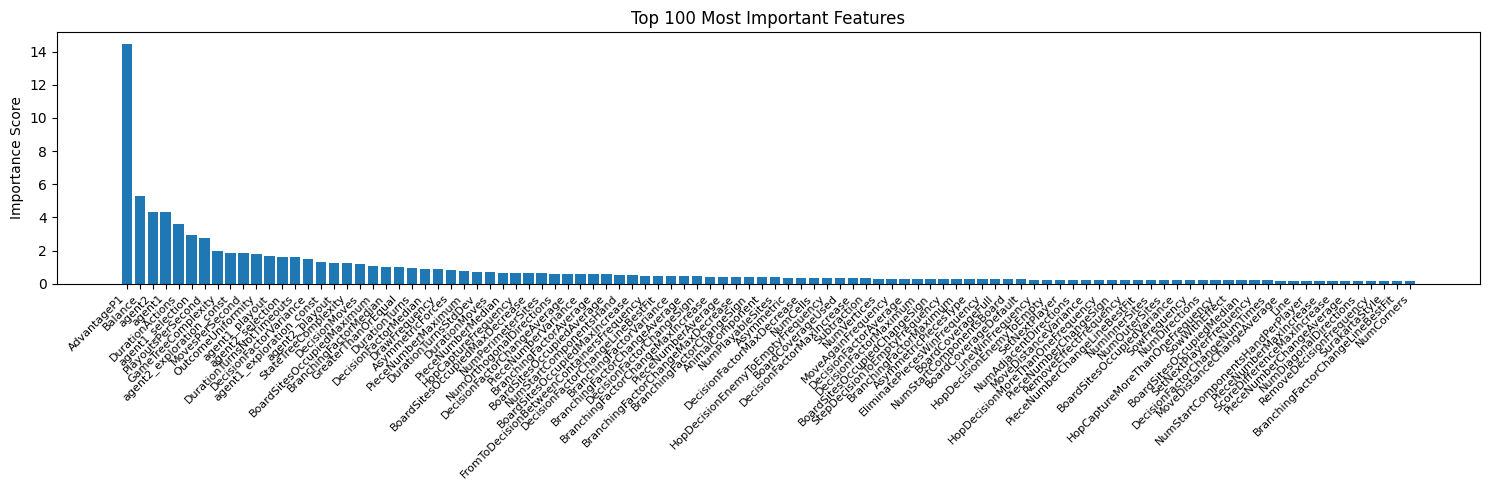

Fold 5 - RMSE: 0.4271519841827177
List of oof scores: [0.42898276234297555, 0.4126912237584462, 0.4159486144129323, 0.421581212875255, 0.4271519841827177]
Average oof score: 0.4212711595144653


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4147
Score: 0.4371
Score: 0.4228
Score: 0.4318
Score: 0.3983
Average CV1 Score: 0.4209

CV2 OOF Scores:
Score: 0.4129
Score: 0.3986
Score: 0.4260
Score: 0.4365
Score: 0.4317
Average CV2 Score: 0.4211

CV3 OOF Scores:
Score: 0.4290
Score: 0.4127
Score: 0.4159
Score: 0.4216
Score: 0.4272
Average CV3 Score: 0.4213


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

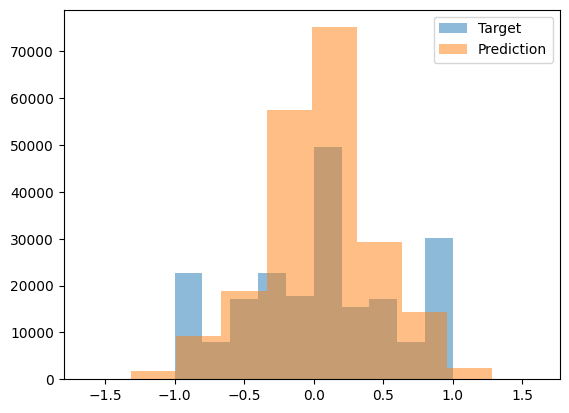

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.134808       │
│ 233235 ┆ -0.162168      │
│ 233236 ┆ -0.01197       │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***